In [1]:
import simpy
import random
from scipy.stats import uniform
from random import expovariate
from scipy import stats
import matplotlib.pyplot as plt

# objetos = [f'Objeto-{i}' for i in range(1,10)]
repetir = []
tiempo={}
pasa = []


Dias_carril_p = 1440
Dias_carril_l = 1440

Dias_ap = 1440
Dias_rech = 1440

Dias = 1440

carr_pesados = 0
vcpes = []
carr_livianos = 0
vcliv = []

dia_vehiculos = 0
vdias = []

aprobados = 0
vap = []
rechasados = 0
vrech = []

tiempos = []

class PROCESO(object):
  def __init__(self, environment):
    # Guardamos como variable el entorno de ejecucion
    self.env=environment
    self.entrada_liviano = simpy.Resource(environment, 2)
    self.entrada_pesado = simpy.Resource(environment, 1)
    self.turno = simpy.Resource(environment, 1)
    self.pago = simpy.Resource(environment, 1)
    self.revision = simpy.Resource(environment, 1)
    self.sello = simpy.Resource(environment, 1)
    self.salida = simpy.Resource(environment, 1)

  def ingreso(self, objeto, pesado):
    global Dias_carril_p
    global Dias_carril_l
    global carr_pesados
    global carr_livianos
    yield self.env.timeout(random.randint(3,5))
    print(f'Estaciona {objeto} tiempo {env.now}')
    if pesado:
      self.entrada_pesado.release(objeto)
      carr_pesados += 1
      if env.now >= Dias_carril_l:
        vcpes.append(carr_pesados)
        carr_pesados = 0
        Dias_carril_l += 1440
    else:
      self.entrada_liviano.release(objeto)
      carr_livianos += 1
      if env.now >= Dias_carril_p:
        vcliv.append(carr_livianos)
        carr_livianos = 0
        Dias_carril_p += 1440

  def sacar_turno(self, objeto):
    yield self.env.timeout(random.randint(1,3))
    print(f'Saca turno {objeto} tiempo {env.now}')
    self.turno.release(objeto)

  def pagar_matricula(self, objeto):
    yield self.env.timeout(random.randint(5,10))
    print(f'Paga matricula {objeto} tiempo {env.now}')
    self.pago.release(objeto)

  def revisar(self, objeto):
    global Dias_rech
    global rechasados
    global vrech
    yield self.env.timeout(abs(int(random.normalvariate(20, 10))))#desviacion estandar 10
    self.revision.release(objeto)
    if random.randint(1,100) < 60:
      print(f'Pasa Revision {objeto} tiempo {env.now}')
    else:
      print(f'No pasa Revision {objeto} tiempo {env.now}')
      rechasados += 1
      pasa.append(objeto)
      if env.now >= Dias_rech:
        vrech.append(rechasados)
        rechasados = 0
        Dias_rech += 1440

  def sellar(self, objeto):
    global Dias_ap
    global aprobados
    global vap
    yield self.env.timeout(random.randint(1,3))
    print(f'Sellado {objeto} tiempo {env.now}')
    self.sello.release(objeto)
    aprobados += 1
    if env.now >= Dias_ap:
      vap.append(aprobados)
      aprobados = 0
      Dias_ap += 1440


  def salir(self, objeto, pesado):
    yield self.env.timeout(random.randint(5,10))
    print(f'Sale {objeto} tiempo {env.now}')
    self.salida.release(objeto)
    if objeto in pasa:
      repetir.append([objeto, env.now+2880, pesado, True])#2 dias es 2880 minutos
      pasa.remove(objeto)
    # if len(repetir) > 0 and repetir[len(repetir)-1][0] == objeto:
    #   repetir[len(repetir)-1][1] = env.now + 5 #2 dias es 2880 minutos
    global Dias
    global dia_vehiculos
    global vdias
    global tiempo
    dia_vehiculos += 1
    k=env.now # Permite obtener el tiempo actual de la simulación para generar la clave del diccionario
    if k in tiempo:
      tiempo[k]=tiempo[k]+1 # Aumento el numero de autos en el tiempo de salida
    else:
      tiempo[k]=1 # Por defecto empezamos con el primer vehiculo

    if env.now >= Dias:
      vdias.append(dia_vehiculos)
      dia_vehiculos = 0
      tiempos.append(tiempo)
      tiempo = {}
      Dias += 1440
      

def llegada_objeto(env, nombre, proceso, pesado, repite):
  # Especificamos que vamos a usar un recurso (Resource) que representa
  if pesado:
    with proceso.entrada_pesado.request() as entrada:
      yield entrada
      yield env.process(proceso.ingreso(nombre, pesado))
  else:
    with proceso.entrada_liviano.request() as entrada:
      yield entrada
      yield env.process(proceso.ingreso(nombre, pesado))

  with proceso.turno.request() as turno:
    yield turno
    yield env.process(proceso.sacar_turno(nombre))
    
  if not repite:
    with proceso.pago.request() as pago:
      yield pago
      yield env.process(proceso.pagar_matricula(nombre))

  with proceso.revision.request() as revision:
    yield revision
    yield env.process(proceso.revisar(nombre))
  
  if nombre not in pasa:
    with proceso.sello.request() as sello:
      yield sello
      yield env.process(proceso.sellar(nombre))

  with proceso.salida.request() as salida:
    yield salida
    yield env.process(proceso.salir(nombre, pesado))

def check_repetir(env, proceso):
  if len(repetir) > 0 :
      for r in repetir:
        if int(r[1]) == env.now:
          print(f'Reingresa {r[0]} en tiempo {env.now}')
          env.process(llegada_objeto(env, r[0], proceso, r[2], r[3]))
          repetir.remove(r)
  

def ejecutar_simulacion(env):
  proceso = PROCESO(env)
  # Creamos las llegadas de los objetos iniciales
  i=0
  while True:
    # print(repetir)
    vehiculo = ''
    pesado = False
    if random.randint(1,100) < 85:
      vehiculo = 'Liviano-%d'%(i+1)
      pesado = False
    else:
      vehiculo = 'Pesado-%d'%(i+1)
      pesado = True
    
    yield env.timeout(1)      
    check_repetir(env, proceso)
    yield env.timeout(1)
    check_repetir(env, proceso)
    yield env.timeout(1)
    check_repetir(env, proceso)

    # yield env.timeout(3)
    print(f'Llega {vehiculo} en tiempo {env.now}')
    env.process(llegada_objeto(env, vehiculo, proceso, pesado, False))
    i+=1
    # if i >= 10:
    #   break
print('Simular')  
random.seed(77)
env=simpy.Environment()
env.process(ejecutar_simulacion(env))
# env.run(80)
env.run(43200)#30 dias en minutos

Simular
Llega Liviano-1 en tiempo 3
Estaciona Liviano-1 tiempo 6
Llega Liviano-2 en tiempo 6
Saca turno Liviano-1 tiempo 7
Estaciona Liviano-2 tiempo 9
Llega Liviano-3 en tiempo 9
Saca turno Liviano-2 tiempo 12
Llega Liviano-4 en tiempo 12
Paga matricula Liviano-1 tiempo 14
Estaciona Liviano-3 tiempo 14
Estaciona Liviano-4 tiempo 15
Llega Liviano-5 en tiempo 15
Saca turno Liviano-3 tiempo 15
Saca turno Liviano-4 tiempo 16
Llega Liviano-6 en tiempo 18
Estaciona Liviano-5 tiempo 19
Paga matricula Liviano-2 tiempo 21
Saca turno Liviano-5 tiempo 21
Llega Liviano-7 en tiempo 21
Estaciona Liviano-6 tiempo 23
Llega Liviano-8 en tiempo 24
Saca turno Liviano-6 tiempo 24
Estaciona Liviano-7 tiempo 25
Saca turno Liviano-7 tiempo 27
Llega Liviano-9 en tiempo 27
Paga matricula Liviano-3 tiempo 28
Estaciona Liviano-8 tiempo 29
Llega Liviano-10 en tiempo 30
Saca turno Liviano-8 tiempo 30
Estaciona Liviano-9 tiempo 31
Saca turno Liviano-9 tiempo 32
Estaciona Liviano-10 tiempo 33
Llega Liviano-11 en ti

Saca turno Liviano-260 tiempo 788
Llega Liviano-263 en tiempo 789
Saca turno Liviano-261 tiempo 790
Estaciona Liviano-262 tiempo 791
Llega Pesado-264 en tiempo 792
Estaciona Liviano-263 tiempo 793
Saca turno Liviano-262 tiempo 794
Estaciona Pesado-264 tiempo 795
Llega Liviano-265 en tiempo 795
Saca turno Liviano-263 tiempo 796
Paga matricula Liviano-106 tiempo 797
Saca turno Pesado-264 tiempo 797
Llega Liviano-266 en tiempo 798
Estaciona Liviano-265 tiempo 799
Saca turno Liviano-265 tiempo 800
Llega Liviano-267 en tiempo 801
Paga matricula Liviano-107 tiempo 802
Estaciona Liviano-266 tiempo 802
Pasa Revision Liviano-39 tiempo 803
Estaciona Liviano-267 tiempo 804
Llega Pesado-268 en tiempo 804
Sellado Liviano-39 tiempo 804
Saca turno Liviano-266 tiempo 805
Saca turno Liviano-267 tiempo 806
Estaciona Pesado-268 tiempo 807
Llega Liviano-269 en tiempo 807
Paga matricula Pesado-108 tiempo 810
Saca turno Pesado-268 tiempo 810
Llega Liviano-270 en tiempo 810
Sale Liviano-39 tiempo 812
Estacio

Saca turno Pesado-451 tiempo 1361
Pasa Revision Liviano-69 tiempo 1362
Llega Liviano-454 en tiempo 1362
Estaciona Pesado-453 tiempo 1364
Saca turno Liviano-452 tiempo 1364
Sellado Liviano-69 tiempo 1364
Llega Liviano-455 en tiempo 1365
Saca turno Pesado-453 tiempo 1365
Estaciona Liviano-454 tiempo 1366
Pasa Revision Liviano-70 tiempo 1366
Paga matricula Liviano-181 tiempo 1368
Saca turno Liviano-454 tiempo 1368
Sellado Liviano-70 tiempo 1368
Llega Pesado-456 en tiempo 1368
Estaciona Liviano-455 tiempo 1369
Saca turno Liviano-455 tiempo 1370
Llega Liviano-457 en tiempo 1371
Sale Liviano-69 tiempo 1373
Estaciona Pesado-456 tiempo 1373
Estaciona Liviano-457 tiempo 1374
Llega Liviano-458 en tiempo 1374
Saca turno Pesado-456 tiempo 1374
Saca turno Liviano-457 tiempo 1377
Llega Pesado-459 en tiempo 1377
Paga matricula Pesado-182 tiempo 1378
Sale Liviano-70 tiempo 1379
Estaciona Liviano-458 tiempo 1379
Llega Liviano-460 en tiempo 1380
Estaciona Pesado-459 tiempo 1382
Saca turno Liviano-458 ti

Sale Pesado-91 tiempo 1780
Estaciona Liviano-593 tiempo 1782
Saca turno Liviano-592 tiempo 1782
Llega Pesado-594 en tiempo 1782
Saca turno Liviano-593 tiempo 1783
Paga matricula Liviano-236 tiempo 1785
Llega Liviano-595 en tiempo 1785
Estaciona Pesado-594 tiempo 1786
No pasa Revision Liviano-92 tiempo 1788
Estaciona Liviano-595 tiempo 1788
Saca turno Pesado-594 tiempo 1788
Llega Pesado-596 en tiempo 1788
Estaciona Pesado-596 tiempo 1791
Saca turno Liviano-595 tiempo 1791
Llega Liviano-597 en tiempo 1791
Saca turno Pesado-596 tiempo 1792
Llega Liviano-598 en tiempo 1794
Paga matricula Liviano-237 tiempo 1795
Estaciona Liviano-597 tiempo 1796
Llega Liviano-599 en tiempo 1797
Sale Liviano-92 tiempo 1798
Estaciona Liviano-598 tiempo 1799
Saca turno Liviano-597 tiempo 1799
Llega Liviano-600 en tiempo 1800
Estaciona Liviano-599 tiempo 1801
Saca turno Liviano-598 tiempo 1802
Estaciona Liviano-600 tiempo 1803
Llega Liviano-601 en tiempo 1803
Saca turno Liviano-599 tiempo 1803
Saca turno Livian

Saca turno Liviano-771 tiempo 2319
Llega Liviano-773 en tiempo 2319
Sale Pesado-117 tiempo 2320
Paga matricula Pesado-303 tiempo 2320
Estaciona Liviano-772 tiempo 2320
Pasa Revision Liviano-119 tiempo 2322
Saca turno Liviano-772 tiempo 2322
Llega Liviano-774 en tiempo 2322
Sellado Liviano-119 tiempo 2323
Estaciona Liviano-773 tiempo 2324
Llega Liviano-775 en tiempo 2325
Estaciona Liviano-774 tiempo 2327
Saca turno Liviano-773 tiempo 2327
Pasa Revision Liviano-120 tiempo 2328
Llega Liviano-776 en tiempo 2328
Saca turno Liviano-774 tiempo 2328
Sale Liviano-118 tiempo 2329
Paga matricula Liviano-304 tiempo 2329
Estaciona Liviano-775 tiempo 2329
Sellado Liviano-120 tiempo 2329
Saca turno Liviano-775 tiempo 2330
Llega Liviano-777 en tiempo 2331
Estaciona Liviano-776 tiempo 2333
Estaciona Liviano-777 tiempo 2334
Llega Liviano-778 en tiempo 2334
Saca turno Liviano-776 tiempo 2336
Llega Liviano-779 en tiempo 2337
Paga matricula Liviano-305 tiempo 2338
Estaciona Liviano-778 tiempo 2338
Sale Liv

Llega Liviano-943 en tiempo 2829
Paga matricula Liviano-370 tiempo 2830
Estaciona Liviano-942 tiempo 2830
Saca turno Liviano-941 tiempo 2831
Llega Pesado-944 en tiempo 2832
Estaciona Liviano-943 tiempo 2834
Saca turno Liviano-942 tiempo 2834
Paga matricula Liviano-371 tiempo 2835
Llega Liviano-945 en tiempo 2835
Saca turno Liviano-943 tiempo 2835
Estaciona Pesado-944 tiempo 2836
Llega Liviano-946 en tiempo 2838
Saca turno Pesado-944 tiempo 2839
Estaciona Liviano-945 tiempo 2840
Paga matricula Liviano-372 tiempo 2840
Estaciona Liviano-946 tiempo 2841
Llega Liviano-947 en tiempo 2841
Saca turno Liviano-945 tiempo 2842
Estaciona Liviano-947 tiempo 2844
Saca turno Liviano-946 tiempo 2844
Llega Liviano-948 en tiempo 2844
No pasa Revision Pesado-144 tiempo 2847
Paga matricula Liviano-373 tiempo 2847
Saca turno Liviano-947 tiempo 2847
Llega Pesado-949 en tiempo 2847
Estaciona Liviano-948 tiempo 2848
Saca turno Liviano-948 tiempo 2849
Llega Liviano-950 en tiempo 2850
Estaciona Pesado-949 tiemp

Sale Liviano-172 tiempo 3393
Estaciona Pesado-1130 tiempo 3393
Llega Liviano-1131 en tiempo 3393
Saca turno Pesado-1130 tiempo 3395
Llega Liviano-1132 en tiempo 3396
Estaciona Liviano-1131 tiempo 3397
Estaciona Liviano-1132 tiempo 3399
Llega Liviano-1133 en tiempo 3399
Saca turno Liviano-1131 tiempo 3400
Paga matricula Liviano-447 tiempo 3401
Llega Liviano-1134 en tiempo 3402
Estaciona Liviano-1133 tiempo 3403
Saca turno Liviano-1132 tiempo 3403
Reingresa Pesado-23 en tiempo 3403
Saca turno Liviano-1133 tiempo 3404
Estaciona Liviano-1134 tiempo 3405
Llega Liviano-1135 en tiempo 3405
Pasa Revision Liviano-173 tiempo 3407
Estaciona Pesado-23 tiempo 3407
Saca turno Liviano-1134 tiempo 3408
Llega Liviano-1136 en tiempo 3408
Estaciona Liviano-1135 tiempo 3409
Sellado Liviano-173 tiempo 3409
Paga matricula Liviano-448 tiempo 3410
Saca turno Pesado-23 tiempo 3411
Llega Liviano-1137 en tiempo 3411
Estaciona Liviano-1136 tiempo 3412
Saca turno Liviano-1135 tiempo 3414
Llega Liviano-1138 en tiem

Saca turno Liviano-1314 tiempo 3949
Paga matricula Liviano-518 tiempo 3950
Saca turno Pesado-1315 tiempo 3951
Llega Liviano-1317 en tiempo 3951
Estaciona Liviano-1316 tiempo 3953
Llega Liviano-1318 en tiempo 3954
Estaciona Liviano-1317 tiempo 3955
Saca turno Liviano-1316 tiempo 3956
Llega Liviano-1319 en tiempo 3957
Saca turno Liviano-1317 tiempo 3958
Paga matricula Pesado-519 tiempo 3959
Estaciona Liviano-1318 tiempo 3959
Reingresa Liviano-54 en tiempo 3959
Estaciona Liviano-1319 tiempo 3960
Llega Pesado-1320 en tiempo 3960
Saca turno Liviano-1318 tiempo 3962
Estaciona Liviano-54 tiempo 3963
Llega Liviano-1321 en tiempo 3963
Saca turno Liviano-1319 tiempo 3963
Estaciona Pesado-1320 tiempo 3964
Saca turno Liviano-54 tiempo 3966
Llega Liviano-1322 en tiempo 3966
Saca turno Pesado-1320 tiempo 3967
Paga matricula Liviano-520 tiempo 3968
Estaciona Liviano-1321 tiempo 3968
Llega Pesado-1323 en tiempo 3969
Saca turno Liviano-1321 tiempo 3969
Estaciona Liviano-1322 tiempo 3970
Pasa Revision L

Llega Liviano-1495 en tiempo 4485
Saca turno Liviano-1493 tiempo 4486
Paga matricula Liviano-590 tiempo 4487
Estaciona Liviano-1495 tiempo 4488
Llega Liviano-1496 en tiempo 4488
Sale Pesado-225 tiempo 4489
Saca turno Liviano-1494 tiempo 4489
Llega Liviano-1497 en tiempo 4491
Estaciona Liviano-1496 tiempo 4492
Saca turno Liviano-1495 tiempo 4492
Estaciona Liviano-1497 tiempo 4494
Saca turno Liviano-1496 tiempo 4494
Llega Liviano-1498 en tiempo 4494
Saca turno Liviano-1497 tiempo 4496
Paga matricula Liviano-591 tiempo 4497
Estaciona Liviano-1498 tiempo 4497
Llega Liviano-1499 en tiempo 4497
Saca turno Liviano-1498 tiempo 4499
Llega Liviano-1500 en tiempo 4500
Estaciona Liviano-1499 tiempo 4502
Llega Liviano-1501 en tiempo 4503
Saca turno Liviano-1499 tiempo 4504
Paga matricula Liviano-592 tiempo 4505
Estaciona Liviano-1500 tiempo 4505
Llega Liviano-1502 en tiempo 4506
Saca turno Liviano-1500 tiempo 4506
Estaciona Liviano-1501 tiempo 4508
Estaciona Liviano-1502 tiempo 4509
Llega Liviano-1

Sale Pesado-253 tiempo 5033
Saca turno Liviano-1675 tiempo 5033
Llega Liviano-1678 en tiempo 5034
Saca turno Pesado-1676 tiempo 5034
Paga matricula Liviano-662 tiempo 5035
Estaciona Liviano-1677 tiempo 5036
Llega Liviano-1679 en tiempo 5037
Estaciona Liviano-1678 tiempo 5038
Saca turno Liviano-1677 tiempo 5038
Llega Liviano-1680 en tiempo 5040
Estaciona Liviano-1679 tiempo 5041
Saca turno Liviano-1678 tiempo 5041
Saca turno Liviano-1679 tiempo 5042
Paga matricula Pesado-663 tiempo 5043
Llega Pesado-1681 en tiempo 5043
Estaciona Liviano-1680 tiempo 5044
Estaciona Pesado-1681 tiempo 5046
Saca turno Liviano-1680 tiempo 5046
Llega Liviano-1682 en tiempo 5046
Saca turno Pesado-1681 tiempo 5047
Paga matricula Liviano-664 tiempo 5048
Llega Liviano-1683 en tiempo 5049
Estaciona Liviano-1682 tiempo 5051
Llega Liviano-1684 en tiempo 5052
Paga matricula Liviano-665 tiempo 5053
Estaciona Liviano-1683 tiempo 5054
Saca turno Liviano-1682 tiempo 5054
Estaciona Liviano-1684 tiempo 5055
Llega Liviano-1

Llega Liviano-1862 en tiempo 5586
Sale Liviano-284 tiempo 5587
Estaciona Liviano-1861 tiempo 5587
Saca turno Liviano-1860 tiempo 5588
Estaciona Liviano-1862 tiempo 5589
Llega Liviano-1863 en tiempo 5589
Saca turno Liviano-1861 tiempo 5591
Paga matricula Liviano-737 tiempo 5592
Estaciona Liviano-1863 tiempo 5592
Llega Liviano-1864 en tiempo 5592
Saca turno Liviano-1862 tiempo 5593
Saca turno Liviano-1863 tiempo 5595
Llega Liviano-1865 en tiempo 5595
Estaciona Liviano-1864 tiempo 5597
Estaciona Liviano-1865 tiempo 5598
Llega Liviano-1866 en tiempo 5598
Paga matricula Liviano-738 tiempo 5600
Saca turno Liviano-1864 tiempo 5600
Llega Liviano-1867 en tiempo 5601
Estaciona Liviano-1866 tiempo 5602
Saca turno Liviano-1865 tiempo 5603
Llega Pesado-1868 en tiempo 5604
Saca turno Liviano-1866 tiempo 5604
Estaciona Liviano-1867 tiempo 5605
Saca turno Liviano-1867 tiempo 5606
Pasa Revision Liviano-285 tiempo 5607
Llega Liviano-1869 en tiempo 5607
Paga matricula Liviano-739 tiempo 5608
Estaciona Pe

Llega Pesado-2030 en tiempo 6090
Estaciona Pesado-2029 tiempo 6091
Saca turno Liviano-2028 tiempo 6092
Llega Pesado-2031 en tiempo 6093
Saca turno Pesado-2029 tiempo 6095
Paga matricula Liviano-802 tiempo 6096
Estaciona Pesado-2030 tiempo 6096
Llega Liviano-2032 en tiempo 6096
Saca turno Pesado-2030 tiempo 6097
Sale Pesado-309 tiempo 6099
Llega Liviano-2033 en tiempo 6099
Estaciona Pesado-2031 tiempo 6100
Pasa Revision Pesado-310 tiempo 6101
Estaciona Liviano-2032 tiempo 6101
Llega Liviano-2034 en tiempo 6102
Estaciona Liviano-2033 tiempo 6103
Saca turno Pesado-2031 tiempo 6103
Sellado Pesado-310 tiempo 6103
Saca turno Liviano-2032 tiempo 6105
Llega Liviano-2035 en tiempo 6105
Paga matricula Liviano-803 tiempo 6106
Estaciona Liviano-2034 tiempo 6107
Estaciona Liviano-2035 tiempo 6108
Saca turno Liviano-2033 tiempo 6108
Llega Pesado-2036 en tiempo 6108
Sale Pesado-310 tiempo 6109
Reingresa Liviano-162 en tiempo 6109
Saca turno Liviano-2034 tiempo 6111
Llega Liviano-2037 en tiempo 6111
E

Saca turno Liviano-2195 tiempo 6590
Llega Pesado-2197 en tiempo 6591
Estaciona Liviano-2196 tiempo 6592
Paga matricula Liviano-868 tiempo 6594
Llega Liviano-2198 en tiempo 6594
Sale Liviano-338 tiempo 6595
Saca turno Liviano-2196 tiempo 6595
Estaciona Pesado-2197 tiempo 6596
Estaciona Liviano-2198 tiempo 6597
Llega Liviano-2199 en tiempo 6597
Saca turno Pesado-2197 tiempo 6597
Saca turno Liviano-2198 tiempo 6599
Reingresa Liviano-186 en tiempo 6599
Llega Liviano-2200 en tiempo 6600
Estaciona Liviano-2199 tiempo 6602
Estaciona Liviano-186 tiempo 6603
Llega Liviano-2201 en tiempo 6603
Paga matricula Liviano-869 tiempo 6604
Saca turno Liviano-2199 tiempo 6605
Llega Liviano-2202 en tiempo 6606
Saca turno Liviano-186 tiempo 6606
Estaciona Liviano-2200 tiempo 6607
Estaciona Liviano-2201 tiempo 6607
No pasa Revision Liviano-339 tiempo 6609
Saca turno Liviano-2200 tiempo 6609
Llega Liviano-2203 en tiempo 6609
Estaciona Liviano-2202 tiempo 6610
Saca turno Liviano-2201 tiempo 6611
Estaciona Livi

Llega Liviano-2405 en tiempo 7215
Saca turno Liviano-2403 tiempo 7215
Pasa Revision Liviano-368 tiempo 7216
Estaciona Liviano-2404 tiempo 7217
Sale Pesado-366 tiempo 7218
Estaciona Liviano-2405 tiempo 7218
Llega Liviano-2406 en tiempo 7218
Paga matricula Liviano-952 tiempo 7219
Sellado Liviano-368 tiempo 7219
Saca turno Liviano-2404 tiempo 7219
Estaciona Liviano-2406 tiempo 7221
Saca turno Liviano-2405 tiempo 7221
Llega Pesado-2407 en tiempo 7221
Saca turno Liviano-2406 tiempo 7223
Llega Liviano-2408 en tiempo 7224
Estaciona Pesado-2407 tiempo 7225
Sale Liviano-367 tiempo 7226
Paga matricula Liviano-953 tiempo 7226
Saca turno Pesado-2407 tiempo 7226
Llega Pesado-2409 en tiempo 7227
Estaciona Liviano-2408 tiempo 7228
Llega Pesado-2410 en tiempo 7230
Saca turno Liviano-2408 tiempo 7231
Paga matricula Liviano-954 tiempo 7232
Estaciona Pesado-2409 tiempo 7232
Llega Liviano-2411 en tiempo 7233
Sale Liviano-368 tiempo 7235
Saca turno Pesado-2409 tiempo 7235
Pasa Revision Liviano-369 tiempo 7

Saca turno Liviano-2591 tiempo 7778
Sale Liviano-393 tiempo 7779
Estaciona Pesado-2592 tiempo 7779
Llega Liviano-2593 en tiempo 7779
Saca turno Pesado-2592 tiempo 7780
Estaciona Liviano-2593 tiempo 7782
Llega Liviano-2594 en tiempo 7782
Estaciona Liviano-2594 tiempo 7785
Saca turno Liviano-2593 tiempo 7785
Llega Liviano-2595 en tiempo 7785
Paga matricula Liviano-1025 tiempo 7786
Saca turno Liviano-2594 tiempo 7787
Llega Pesado-2596 en tiempo 7788
Estaciona Liviano-2595 tiempo 7789
Estaciona Pesado-2596 tiempo 7791
Llega Liviano-2597 en tiempo 7791
Saca turno Liviano-2595 tiempo 7792
Saca turno Pesado-2596 tiempo 7793
Pasa Revision Liviano-394 tiempo 7794
Llega Pesado-2598 en tiempo 7794
Paga matricula Liviano-1026 tiempo 7795
Estaciona Liviano-2597 tiempo 7795
Sellado Liviano-394 tiempo 7796
Estaciona Pesado-2598 tiempo 7797
Llega Liviano-2599 en tiempo 7797
Saca turno Liviano-2597 tiempo 7798
Saca turno Pesado-2598 tiempo 7799
Estaciona Liviano-2599 tiempo 7800
Llega Liviano-2600 en t

Estaciona Liviano-2772 tiempo 8321
Saca turno Liviano-2771 tiempo 8321
Estaciona Liviano-2773 tiempo 8322
Llega Liviano-2774 en tiempo 8322
Saca turno Liviano-2772 tiempo 8324
Sale Liviano-418 tiempo 8325
Llega Liviano-2775 en tiempo 8325
Paga matricula Liviano-1096 tiempo 8327
Estaciona Liviano-2774 tiempo 8327
Saca turno Liviano-2773 tiempo 8327
Llega Liviano-2776 en tiempo 8328
Saca turno Liviano-2774 tiempo 8329
Estaciona Liviano-2775 tiempo 8330
Llega Pesado-2777 en tiempo 8331
Estaciona Liviano-2776 tiempo 8333
Saca turno Liviano-2775 tiempo 8333
Llega Liviano-2778 en tiempo 8334
Saca turno Liviano-2776 tiempo 8334
Sale Pesado-419 tiempo 8335
Paga matricula Liviano-1097 tiempo 8335
Estaciona Pesado-2777 tiempo 8335
Saca turno Pesado-2777 tiempo 8337
Llega Liviano-2779 en tiempo 8337
Estaciona Liviano-2778 tiempo 8338
Estaciona Liviano-2779 tiempo 8340
Saca turno Liviano-2778 tiempo 8340
Llega Liviano-2780 en tiempo 8340
Paga matricula Liviano-1098 tiempo 8341
Saca turno Liviano-2

Saca turno Liviano-2925 tiempo 8781
Paga matricula Liviano-1157 tiempo 8782
Estaciona Liviano-2926 tiempo 8783
Llega Liviano-2928 en tiempo 8784
Saca turno Liviano-2926 tiempo 8784
Pasa Revision Liviano-439 tiempo 8785
Estaciona Liviano-2927 tiempo 8785
Saca turno Liviano-2927 tiempo 8786
Sellado Liviano-439 tiempo 8787
Llega Liviano-2929 en tiempo 8787
Estaciona Liviano-2928 tiempo 8789
Estaciona Liviano-2929 tiempo 8790
Llega Liviano-2930 en tiempo 8790
Paga matricula Pesado-1158 tiempo 8792
Saca turno Liviano-2928 tiempo 8792
Llega Liviano-2931 en tiempo 8793
Sale Liviano-439 tiempo 8794
Saca turno Liviano-2929 tiempo 8794
Estaciona Liviano-2930 tiempo 8795
Estaciona Liviano-2931 tiempo 8796
Llega Liviano-2932 en tiempo 8796
Saca turno Liviano-2930 tiempo 8797
Saca turno Liviano-2931 tiempo 8798
Llega Liviano-2933 en tiempo 8799
Estaciona Liviano-2932 tiempo 8801
Reingresa Liviano-298 en tiempo 8801
Paga matricula Liviano-1159 tiempo 8802
Llega Liviano-2934 en tiempo 8802
Saca turno

Sale Liviano-26 tiempo 9190
Estaciona Liviano-3062 tiempo 9191
Estaciona Pesado-3063 tiempo 9192
Saca turno Liviano-3061 tiempo 9192
Llega Liviano-3064 en tiempo 9192
Saca turno Liviano-3062 tiempo 9194
Llega Pesado-3065 en tiempo 9195
Paga matricula Liviano-1210 tiempo 9196
Estaciona Liviano-3064 tiempo 9196
Saca turno Pesado-3063 tiempo 9196
Saca turno Liviano-3064 tiempo 9197
Llega Pesado-3066 en tiempo 9198
Estaciona Pesado-3065 tiempo 9199
Paga matricula Liviano-1211 tiempo 9201
Llega Pesado-3067 en tiempo 9201
Saca turno Pesado-3065 tiempo 9202
Estaciona Pesado-3066 tiempo 9203
Llega Pesado-3068 en tiempo 9204
Saca turno Pesado-3066 tiempo 9204
Reingresa Liviano-320 en tiempo 9205
Estaciona Pesado-3067 tiempo 9206
Paga matricula Liviano-1212 tiempo 9207
Llega Liviano-3069 en tiempo 9207
Pasa Revision Liviano-455 tiempo 9208
Saca turno Pesado-3067 tiempo 9208
Estaciona Liviano-320 tiempo 9209
Estaciona Pesado-3068 tiempo 9210
Sellado Liviano-455 tiempo 9210
Llega Liviano-3070 en t

Pasa Revision Liviano-476 tiempo 9805
Estaciona Liviano-3267 tiempo 9806
Saca turno Liviano-3266 tiempo 9806
Llega Liviano-3269 en tiempo 9807
Paga matricula Liviano-1293 tiempo 9808
Estaciona Liviano-3268 tiempo 9808
Sellado Liviano-476 tiempo 9808
Saca turno Liviano-3267 tiempo 9808
Estaciona Liviano-3269 tiempo 9810
Llega Liviano-3270 en tiempo 9810
Saca turno Liviano-3268 tiempo 9811
Saca turno Liviano-3269 tiempo 9813
Llega Liviano-3271 en tiempo 9813
Sale Liviano-476 tiempo 9815
Estaciona Liviano-3270 tiempo 9815
Paga matricula Liviano-1294 tiempo 9816
Llega Liviano-3272 en tiempo 9816
Estaciona Liviano-3271 tiempo 9817
Saca turno Liviano-3270 tiempo 9818
Llega Liviano-3273 en tiempo 9819
Saca turno Liviano-3271 tiempo 9819
Estaciona Liviano-3272 tiempo 9820
Paga matricula Liviano-1295 tiempo 9821
Saca turno Liviano-3272 tiempo 9821
Estaciona Liviano-3273 tiempo 9822
Llega Liviano-3274 en tiempo 9822
No pasa Revision Liviano-477 tiempo 9823
Estaciona Liviano-3274 tiempo 9825
Saca

Estaciona Liviano-3415 tiempo 10248
Llega Liviano-3416 en tiempo 10248
Saca turno Pesado-3414 tiempo 10248
Sale Pesado-501 tiempo 10251
Saca turno Liviano-3415 tiempo 10251
Llega Liviano-3417 en tiempo 10251
Estaciona Liviano-3416 tiempo 10252
Paga matricula Liviano-1355 tiempo 10254
Llega Liviano-3418 en tiempo 10254
Saca turno Liviano-3416 tiempo 10255
Estaciona Liviano-3417 tiempo 10256
Llega Liviano-3419 en tiempo 10257
Estaciona Liviano-3418 tiempo 10259
Saca turno Liviano-3417 tiempo 10259
Estaciona Liviano-3419 tiempo 10260
Llega Liviano-3420 en tiempo 10260
Saca turno Liviano-3418 tiempo 10261
Pasa Revision Liviano-46 tiempo 10262
Reingresa Liviano-375 en tiempo 10262
Llega Liviano-3421 en tiempo 10263
Paga matricula Liviano-1356 tiempo 10264
Estaciona Liviano-3420 tiempo 10264
Saca turno Liviano-3419 tiempo 10264
Sellado Liviano-46 tiempo 10265
Saca turno Liviano-3420 tiempo 10266
Llega Liviano-3422 en tiempo 10266
Estaciona Liviano-375 tiempo 10267
Estaciona Liviano-3421 tiem

Saca turno Liviano-3592 tiempo 10781
Llega Liviano-3594 en tiempo 10782
Estaciona Liviano-3593 tiempo 10783
Saca turno Liviano-3593 tiempo 10784
Llega Liviano-3595 en tiempo 10785
Paga matricula Pesado-1426 tiempo 10786
Pasa Revision Liviano-521 tiempo 10787
Estaciona Liviano-3594 tiempo 10787
Llega Liviano-3596 en tiempo 10788
Sellado Liviano-521 tiempo 10789
Saca turno Liviano-3594 tiempo 10789
Estaciona Liviano-3595 tiempo 10790
Reingresa Liviano-6 en tiempo 10790
Paga matricula Liviano-1427 tiempo 10791
Llega Liviano-3597 en tiempo 10791
No pasa Revision Liviano-55 tiempo 10792
Estaciona Liviano-3596 tiempo 10793
Saca turno Liviano-3595 tiempo 10793
Estaciona Liviano-6 tiempo 10793
Llega Liviano-3598 en tiempo 10794
Paga matricula Liviano-1428 tiempo 10796
Estaciona Liviano-3597 tiempo 10796
Saca turno Liviano-3596 tiempo 10796
Llega Liviano-3599 en tiempo 10797
Sale Liviano-521 tiempo 10798
Saca turno Liviano-6 tiempo 10798
Estaciona Liviano-3598 tiempo 10799
Saca turno Liviano-35

Sale Liviano-544 tiempo 11320
Estaciona Liviano-3772 tiempo 11320
Estaciona Liviano-3773 tiempo 11322
Saca turno Liviano-3771 tiempo 11322
Llega Liviano-3774 en tiempo 11322
Saca turno Liviano-3772 tiempo 11324
Paga matricula Liviano-1499 tiempo 11325
Llega Liviano-3775 en tiempo 11325
Saca turno Liviano-3773 tiempo 11326
Estaciona Liviano-3774 tiempo 11327
Estaciona Liviano-3775 tiempo 11328
Llega Liviano-3776 en tiempo 11328
Saca turno Liviano-3774 tiempo 11329
No pasa Revision Liviano-64 tiempo 11330
Estaciona Liviano-3776 tiempo 11331
Saca turno Liviano-3775 tiempo 11331
Llega Liviano-3777 en tiempo 11331
Saca turno Liviano-3776 tiempo 11333
Estaciona Liviano-3777 tiempo 11334
Llega Pesado-3778 en tiempo 11334
Paga matricula Liviano-1500 tiempo 11335
Saca turno Liviano-3777 tiempo 11335
Llega Liviano-3779 en tiempo 11337
Sale Liviano-64 tiempo 11339
Estaciona Pesado-3778 tiempo 11339
Llega Liviano-3780 en tiempo 11340
Estaciona Liviano-3779 tiempo 11341
Saca turno Pesado-3778 tiemp

Estaciona Liviano-3971 tiempo 11917
Saca turno Liviano-3969 tiempo 11917
Sale Liviano-571 tiempo 11919
Estaciona Liviano-3972 tiempo 11919
Llega Pesado-3973 en tiempo 11919
Paga matricula Liviano-1577 tiempo 11920
Saca turno Liviano-3970 tiempo 11920
Saca turno Liviano-3971 tiempo 11921
Llega Liviano-3974 en tiempo 11922
Estaciona Pesado-3973 tiempo 11923
Saca turno Liviano-3972 tiempo 11923
Saca turno Pesado-3973 tiempo 11924
Paga matricula Liviano-1578 tiempo 11925
Llega Liviano-3975 en tiempo 11925
Estaciona Liviano-3974 tiempo 11927
Estaciona Liviano-3975 tiempo 11928
Reingresa Liviano-449 en tiempo 11928
Llega Pesado-3976 en tiempo 11928
Saca turno Liviano-3974 tiempo 11928
Saca turno Liviano-3975 tiempo 11929
Llega Liviano-3977 en tiempo 11931
Estaciona Liviano-449 tiempo 11933
Estaciona Pesado-3976 tiempo 11933
Llega Liviano-3978 en tiempo 11934
Paga matricula Liviano-1579 tiempo 11935
Saca turno Liviano-449 tiempo 11935
Estaciona Liviano-3977 tiempo 11936
Saca turno Pesado-3976

Sale Liviano-597 tiempo 12575
Saca turno Liviano-4189 tiempo 12575
Llega Liviano-4192 en tiempo 12576
Saca turno Liviano-4190 tiempo 12577
Estaciona Liviano-4191 tiempo 12578
Paga matricula Pesado-1666 tiempo 12579
Llega Pesado-4193 en tiempo 12579
Estaciona Liviano-4192 tiempo 12580
Saca turno Liviano-4191 tiempo 12581
Llega Pesado-4194 en tiempo 12582
Saca turno Liviano-4192 tiempo 12582
Pasa Revision Liviano-598 tiempo 12583
Sale Liviano-86 tiempo 12584
Estaciona Pesado-4193 tiempo 12584
Sellado Liviano-598 tiempo 12585
Llega Pesado-4195 en tiempo 12585
Paga matricula Liviano-1667 tiempo 12586
Saca turno Pesado-4193 tiempo 12587
Estaciona Pesado-4194 tiempo 12587
Llega Liviano-4196 en tiempo 12588
Saca turno Pesado-4194 tiempo 12589
Sale Liviano-598 tiempo 12591
Estaciona Pesado-4195 tiempo 12591
Estaciona Liviano-4196 tiempo 12591
Llega Liviano-4197 en tiempo 12591
Paga matricula Liviano-1668 tiempo 12594
Saca turno Pesado-4195 tiempo 12594
Llega Liviano-4198 en tiempo 12594
Estaci

Estaciona Liviano-4317 tiempo 12954
Llega Liviano-4318 en tiempo 12954
Paga matricula Liviano-1717 tiempo 12955
Saca turno Liviano-490 tiempo 12955
Saca turno Liviano-4316 tiempo 12956
Sale Liviano-613 tiempo 12957
Llega Liviano-4319 en tiempo 12957
Estaciona Liviano-4318 tiempo 12959
Saca turno Liviano-4317 tiempo 12959
Estaciona Liviano-4319 tiempo 12960
Llega Liviano-4320 en tiempo 12960
Saca turno Liviano-4318 tiempo 12960
Saca turno Liviano-4319 tiempo 12961
Paga matricula Liviano-1718 tiempo 12963
Llega Liviano-4321 en tiempo 12963
Pasa Revision Liviano-614 tiempo 12964
Estaciona Liviano-4320 tiempo 12964
Saca turno Liviano-4320 tiempo 12965
Sellado Liviano-614 tiempo 12966
Llega Liviano-4322 en tiempo 12966
Estaciona Liviano-4321 tiempo 12967
Paga matricula Liviano-1719 tiempo 12969
Reingresa Liviano-491 en tiempo 12969
Llega Pesado-4323 en tiempo 12969
Estaciona Liviano-4322 tiempo 12970
Saca turno Liviano-4321 tiempo 12970
Sale Liviano-614 tiempo 12972
Estaciona Pesado-4323 ti

Saca turno Liviano-4483 tiempo 13454
Paga matricula Liviano-1783 tiempo 13455
Llega Liviano-4485 en tiempo 13455
Estaciona Liviano-4484 tiempo 13457
Llega Liviano-4486 en tiempo 13458
Estaciona Liviano-4485 tiempo 13459
Saca turno Liviano-4484 tiempo 13460
Llega Liviano-4487 en tiempo 13461
Saca turno Liviano-4485 tiempo 13461
Estaciona Liviano-4486 tiempo 13462
Sale Liviano-637 tiempo 13463
Saca turno Liviano-4486 tiempo 13463
Paga matricula Liviano-1784 tiempo 13464
Estaciona Liviano-4487 tiempo 13464
Llega Liviano-4488 en tiempo 13464
Saca turno Liviano-4487 tiempo 13465
Llega Liviano-4489 en tiempo 13467
Estaciona Liviano-4488 tiempo 13468
Saca turno Liviano-4488 tiempo 13470
Reingresa Liviano-515 en tiempo 13470
Llega Liviano-4490 en tiempo 13470
Paga matricula Liviano-1785 tiempo 13471
Estaciona Liviano-4489 tiempo 13471
Saca turno Liviano-4489 tiempo 13472
Estaciona Liviano-515 tiempo 13473
Llega Pesado-4491 en tiempo 13473
Saca turno Liviano-515 tiempo 13474
Paga matricula Livi

Estaciona Liviano-4634 tiempo 13906
Reingresa Liviano-533 en tiempo 13907
Saca turno Liviano-4634 tiempo 13907
Sale Liviano-653 tiempo 13908
Estaciona Liviano-4635 tiempo 13908
Llega Pesado-4636 en tiempo 13908
Saca turno Liviano-4635 tiempo 13909
Estaciona Liviano-533 tiempo 13910
Estaciona Pesado-4636 tiempo 13911
Llega Pesado-4637 en tiempo 13911
Saca turno Liviano-533 tiempo 13911
Paga matricula Liviano-1843 tiempo 13912
Saca turno Pesado-4636 tiempo 13912
Llega Pesado-4638 en tiempo 13914
Estaciona Pesado-4637 tiempo 13915
Saca turno Pesado-4637 tiempo 13916
Llega Liviano-4639 en tiempo 13917
No pasa Revision Liviano-654 tiempo 13918
Estaciona Pesado-4638 tiempo 13919
Estaciona Liviano-4639 tiempo 13920
Llega Pesado-4640 en tiempo 13920
Paga matricula Liviano-1844 tiempo 13921
Saca turno Pesado-4638 tiempo 13922
Llega Liviano-4641 en tiempo 13923
Sale Liviano-654 tiempo 13924
Saca turno Liviano-4639 tiempo 13924
Estaciona Pesado-4640 tiempo 13925
Llega Liviano-4642 en tiempo 13926

Paga matricula Liviano-1903 tiempo 14364
Llega Liviano-4788 en tiempo 14364
Sellado Liviano-113 tiempo 14364
Estaciona Pesado-4787 tiempo 14365
Saca turno Pesado-4787 tiempo 14367
Llega Liviano-4789 en tiempo 14367
Estaciona Liviano-4788 tiempo 14368
Saca turno Liviano-4788 tiempo 14370
Llega Pesado-4790 en tiempo 14370
Estaciona Liviano-4789 tiempo 14372
Sale Liviano-113 tiempo 14373
Paga matricula Liviano-1904 tiempo 14373
Llega Pesado-4791 en tiempo 14373
Estaciona Pesado-4790 tiempo 14374
Saca turno Liviano-4789 tiempo 14374
Saca turno Pesado-4790 tiempo 14376
Llega Liviano-4792 en tiempo 14376
Estaciona Pesado-4791 tiempo 14377
Saca turno Pesado-4791 tiempo 14378
Estaciona Liviano-4792 tiempo 14379
Llega Liviano-4793 en tiempo 14379
Paga matricula Liviano-1905 tiempo 14381
Saca turno Liviano-4792 tiempo 14382
Llega Liviano-4794 en tiempo 14382
Estaciona Liviano-4793 tiempo 14384
Estaciona Liviano-4794 tiempo 14385
Llega Liviano-4795 en tiempo 14385
Saca turno Liviano-4793 tiempo 1

Saca turno Liviano-4996 tiempo 14995
Estaciona Liviano-4997 tiempo 14996
Estaciona Liviano-4998 tiempo 14997
Llega Liviano-4999 en tiempo 14997
Saca turno Liviano-4997 tiempo 14997
Sale Liviano-693 tiempo 14998
Saca turno Liviano-4998 tiempo 14998
Pasa Revision Liviano-121 tiempo 15000
Estaciona Liviano-4999 tiempo 15000
Llega Liviano-5000 en tiempo 15000
Saca turno Liviano-4999 tiempo 15001
Sellado Liviano-121 tiempo 15003
Llega Liviano-5001 en tiempo 15003
Paga matricula Liviano-1990 tiempo 15004
Estaciona Liviano-5000 tiempo 15005
Llega Liviano-5002 en tiempo 15006
Saca turno Liviano-5000 tiempo 15007
Estaciona Liviano-5001 tiempo 15008
Sale Liviano-121 tiempo 15008
Estaciona Liviano-5002 tiempo 15009
Llega Liviano-5003 en tiempo 15009
Paga matricula Liviano-1991 tiempo 15010
Saca turno Liviano-5001 tiempo 15011
Pasa Revision Liviano-694 tiempo 15012
Llega Liviano-5004 en tiempo 15012
Saca turno Liviano-5002 tiempo 15013
Estaciona Liviano-5003 tiempo 15014
Estaciona Liviano-5004 tie

Estaciona Liviano-5171 tiempo 15516
Saca turno Liviano-5170 tiempo 15516
Llega Liviano-5172 en tiempo 15516
Paga matricula Liviano-2058 tiempo 15517
Estaciona Liviano-5172 tiempo 15519
Saca turno Liviano-5171 tiempo 15519
Llega Liviano-5173 en tiempo 15519
Saca turno Liviano-5172 tiempo 15522
Llega Liviano-5174 en tiempo 15522
Paga matricula Pesado-2059 tiempo 15523
Estaciona Liviano-5173 tiempo 15523
Saca turno Liviano-5173 tiempo 15524
Pasa Revision Liviano-719 tiempo 15525
Llega Pesado-5175 en tiempo 15525
Estaciona Liviano-5174 tiempo 15527
Paga matricula Liviano-2060 tiempo 15528
Sellado Liviano-719 tiempo 15528
Llega Liviano-5176 en tiempo 15528
Estaciona Pesado-5175 tiempo 15529
Saca turno Liviano-5174 tiempo 15530
Estaciona Liviano-5176 tiempo 15531
Llega Pesado-5177 en tiempo 15531
Saca turno Pesado-5175 tiempo 15533
Paga matricula Liviano-2061 tiempo 15534
Llega Liviano-5178 en tiempo 15534
Saca turno Liviano-5176 tiempo 15534
Estaciona Pesado-5177 tiempo 15536
Llega Pesado-5

Estaciona Liviano-5321 tiempo 15966
Saca turno Pesado-5320 tiempo 15966
Llega Liviano-5322 en tiempo 15966
Pasa Revision Liviano-743 tiempo 15967
Saca turno Liviano-5321 tiempo 15967
Paga matricula Liviano-2117 tiempo 15969
Sellado Liviano-743 tiempo 15969
Llega Liviano-5323 en tiempo 15969
Estaciona Liviano-5322 tiempo 15971
Llega Liviano-5324 en tiempo 15972
Estaciona Liviano-5323 tiempo 15973
Saca turno Liviano-5322 tiempo 15973
Sale Liviano-743 tiempo 15975
Paga matricula Liviano-2118 tiempo 15975
Estaciona Liviano-5324 tiempo 15975
Saca turno Liviano-5323 tiempo 15975
Llega Pesado-5325 en tiempo 15975
Estaciona Pesado-5325 tiempo 15978
Saca turno Liviano-5324 tiempo 15978
Llega Liviano-5326 en tiempo 15978
Saca turno Pesado-5325 tiempo 15980
Paga matricula Liviano-2119 tiempo 15981
Llega Liviano-5327 en tiempo 15981
Estaciona Liviano-5326 tiempo 15983
Llega Liviano-5328 en tiempo 15984
Estaciona Liviano-5327 tiempo 15985
Saca turno Liviano-5326 tiempo 15985
Llega Liviano-5329 en t

Saca turno Liviano-5486 tiempo 16468
Estaciona Liviano-5488 tiempo 16469
Estaciona Liviano-5489 tiempo 16470
Saca turno Liviano-5487 tiempo 16470
Reingresa Pesado-642 en tiempo 16470
Llega Liviano-5490 en tiempo 16470
Saca turno Liviano-5488 tiempo 16471
Saca turno Liviano-5489 tiempo 16473
Llega Liviano-5491 en tiempo 16473
Estaciona Liviano-5490 tiempo 16474
Paga matricula Liviano-2183 tiempo 16475
Estaciona Pesado-642 tiempo 16475
Llega Liviano-5492 en tiempo 16476
Pasa Revision Liviano-761 tiempo 16477
Estaciona Liviano-5491 tiempo 16477
Saca turno Liviano-5490 tiempo 16477
Sellado Liviano-761 tiempo 16478
Saca turno Pesado-642 tiempo 16478
Llega Liviano-5493 en tiempo 16479
Saca turno Liviano-5491 tiempo 16479
Estaciona Liviano-5492 tiempo 16480
Llega Liviano-5494 en tiempo 16482
Estaciona Liviano-5493 tiempo 16483
Saca turno Liviano-5492 tiempo 16483
Paga matricula Pesado-2184 tiempo 16484
Saca turno Liviano-5493 tiempo 16484
Sale Liviano-761 tiempo 16485
Llega Liviano-5495 en ti

Paga matricula Liviano-2259 tiempo 17058
Llega Liviano-5686 en tiempo 17058
Estaciona Liviano-5685 tiempo 17059
Reingresa Pesado-663 en tiempo 17059
No pasa Revision Liviano-790 tiempo 17060
Saca turno Liviano-5684 tiempo 17060
Llega Liviano-5687 en tiempo 17061
Estaciona Liviano-5686 tiempo 17062
Estaciona Pesado-663 tiempo 17062
Saca turno Liviano-5685 tiempo 17062
Saca turno Liviano-5686 tiempo 17063
Estaciona Liviano-5687 tiempo 17064
Llega Liviano-5688 en tiempo 17064
Paga matricula Pesado-2260 tiempo 17065
Saca turno Pesado-663 tiempo 17065
Saca turno Liviano-5687 tiempo 17066
Llega Liviano-5689 en tiempo 17067
Sale Liviano-790 tiempo 17069
Estaciona Liviano-5688 tiempo 17069
Llega Liviano-5690 en tiempo 17070
Saca turno Liviano-5688 tiempo 17070
Paga matricula Pesado-2261 tiempo 17071
Estaciona Liviano-5689 tiempo 17072
Llega Liviano-5691 en tiempo 17073
Estaciona Liviano-5690 tiempo 17074
Saca turno Liviano-5689 tiempo 17074
Saca turno Liviano-5690 tiempo 17076
Llega Liviano-56

Reingresa Liviano-685 en tiempo 17626
Estaciona Liviano-5874 tiempo 17627
Saca turno Pesado-5873 tiempo 17627
Llega Liviano-5876 en tiempo 17628
Estaciona Liviano-5875 tiempo 17629
Estaciona Liviano-685 tiempo 17630
Saca turno Liviano-5874 tiempo 17630
Llega Liviano-5877 en tiempo 17631
Saca turno Liviano-5875 tiempo 17631
Sale Liviano-812 tiempo 17632
Paga matricula Liviano-2336 tiempo 17633
Estaciona Liviano-5876 tiempo 17633
Saca turno Liviano-685 tiempo 17633
Llega Liviano-5878 en tiempo 17634
Saca turno Liviano-5876 tiempo 17634
Estaciona Liviano-5877 tiempo 17636
Estaciona Liviano-5878 tiempo 17637
Llega Liviano-5879 en tiempo 17637
Saca turno Liviano-5877 tiempo 17638
Llega Liviano-5880 en tiempo 17640
Estaciona Liviano-5879 tiempo 17641
Saca turno Liviano-5878 tiempo 17641
Paga matricula Pesado-2337 tiempo 17642
Saca turno Liviano-5879 tiempo 17642
Estaciona Liviano-5880 tiempo 17643
Llega Pesado-5881 en tiempo 17643
Reingresa Liviano-686 en tiempo 17644
Pasa Revision Pesado-81

Estaciona Liviano-6082 tiempo 18251
Llega Liviano-6084 en tiempo 18252
Saca turno Liviano-6082 tiempo 18252
Estaciona Liviano-6083 tiempo 18254
Paga matricula Liviano-2417 tiempo 18254
Llega Liviano-6085 en tiempo 18255
Saca turno Liviano-6083 tiempo 18255
Estaciona Liviano-6084 tiempo 18257
Llega Pesado-6086 en tiempo 18258
Estaciona Liviano-6085 tiempo 18260
Saca turno Liviano-6084 tiempo 18260
Estaciona Pesado-6086 tiempo 18261
Llega Liviano-6087 en tiempo 18261
No pasa Revision Liviano-840 tiempo 18262
Paga matricula Pesado-2418 tiempo 18262
Saca turno Liviano-6085 tiempo 18263
Estaciona Liviano-6087 tiempo 18264
Llega Liviano-6088 en tiempo 18264
Saca turno Pesado-6086 tiempo 18266
Sale Liviano-840 tiempo 18267
Llega Liviano-6089 en tiempo 18267
Saca turno Liviano-6087 tiempo 18267
Paga matricula Liviano-2419 tiempo 18269
Estaciona Liviano-6088 tiempo 18269
Estaciona Liviano-6089 tiempo 18270
Llega Liviano-6090 en tiempo 18270
Saca turno Liviano-6088 tiempo 18271
Llega Liviano-609

Saca turno Liviano-6204 tiempo 18620
Llega Liviano-6207 en tiempo 18621
Saca turno Liviano-6205 tiempo 18621
Estaciona Pesado-6206 tiempo 18622
Pasa Revision Liviano-855 tiempo 18623
Saca turno Pesado-6206 tiempo 18623
Reingresa Liviano-729 en tiempo 18624
Llega Liviano-6208 en tiempo 18624
Paga matricula Liviano-2465 tiempo 18625
Sellado Liviano-855 tiempo 18625
Estaciona Liviano-6207 tiempo 18626
No pasa Revision Liviano-856 tiempo 18626
Llega Liviano-6209 en tiempo 18627
Estaciona Liviano-729 tiempo 18628
Saca turno Liviano-6207 tiempo 18628
Sale Liviano-854 tiempo 18630
Saca turno Liviano-729 tiempo 18630
Llega Liviano-6210 en tiempo 18630
Estaciona Liviano-6208 tiempo 18631
Estaciona Liviano-6209 tiempo 18633
Saca turno Liviano-6208 tiempo 18633
Llega Liviano-6211 en tiempo 18633
Paga matricula Liviano-2466 tiempo 18635
Estaciona Liviano-6210 tiempo 18635
Estaciona Liviano-6211 tiempo 18636
Saca turno Liviano-6209 tiempo 18636
Llega Liviano-6212 en tiempo 18636
Sale Liviano-855 ti

Estaciona Liviano-6385 tiempo 19159
Saca turno Liviano-6384 tiempo 19160
Paga matricula Liviano-2535 tiempo 19161
Llega Liviano-6387 en tiempo 19161
Saca turno Liviano-6385 tiempo 19162
Estaciona Liviano-6386 tiempo 19163
Sale Pesado-878 tiempo 19164
Estaciona Liviano-6387 tiempo 19164
Llega Liviano-6388 en tiempo 19164
Saca turno Liviano-6386 tiempo 19166
Estaciona Liviano-6388 tiempo 19167
Llega Liviano-6389 en tiempo 19167
Saca turno Liviano-6387 tiempo 19169
Llega Liviano-6390 en tiempo 19170
Saca turno Liviano-6388 tiempo 19170
Paga matricula Pesado-2536 tiempo 19171
Estaciona Liviano-6389 tiempo 19172
Estaciona Liviano-6390 tiempo 19173
Llega Pesado-6391 en tiempo 19173
Saca turno Liviano-6389 tiempo 19174
Saca turno Liviano-6390 tiempo 19175
Llega Pesado-6392 en tiempo 19176
Paga matricula Liviano-2537 tiempo 19177
Estaciona Pesado-6391 tiempo 19177
Llega Liviano-6393 en tiempo 19179
Pasa Revision Liviano-879 tiempo 19180
Saca turno Pesado-6391 tiempo 19180
Sellado Liviano-879 t

No pasa Revision Liviano-197 tiempo 19567
Saca turno Liviano-6521 tiempo 19567
Estaciona Liviano-6522 tiempo 19569
Llega Liviano-6523 en tiempo 19569
Saca turno Liviano-6522 tiempo 19571
Sale Liviano-197 tiempo 19572
Llega Liviano-6524 en tiempo 19572
Estaciona Liviano-6523 tiempo 19574
Paga matricula Liviano-2588 tiempo 19575
Estaciona Liviano-6524 tiempo 19575
Llega Liviano-6525 en tiempo 19575
Saca turno Liviano-6523 tiempo 19576
Saca turno Liviano-6524 tiempo 19577
Llega Liviano-6526 en tiempo 19578
Estaciona Liviano-6525 tiempo 19579
Llega Liviano-6527 en tiempo 19581
Estaciona Liviano-6526 tiempo 19582
Saca turno Liviano-6525 tiempo 19582
Paga matricula Liviano-2589 tiempo 19583
Saca turno Liviano-6526 tiempo 19583
Llega Liviano-6528 en tiempo 19584
No pasa Revision Liviano-896 tiempo 19585
Estaciona Liviano-6527 tiempo 19586
Llega Liviano-6529 en tiempo 19587
Saca turno Liviano-6527 tiempo 19587
Estaciona Liviano-6528 tiempo 19588
Estaciona Liviano-6529 tiempo 19590
Llega Livian

Saca turno Liviano-6706 tiempo 20122
Estaciona Pesado-6707 tiempo 20124
Llega Liviano-6708 en tiempo 20124
Saca turno Pesado-6707 tiempo 20125
Llega Liviano-6709 en tiempo 20127
Estaciona Liviano-6708 tiempo 20129
Llega Liviano-6710 en tiempo 20130
Paga matricula Liviano-2659 tiempo 20131
Saca turno Liviano-6708 tiempo 20131
Reingresa Liviano-797 en tiempo 20131
Estaciona Liviano-6709 tiempo 20132
No pasa Revision Liviano-921 tiempo 20133
Llega Liviano-6711 en tiempo 20133
Estaciona Liviano-6710 tiempo 20134
Saca turno Liviano-6709 tiempo 20135
Llega Liviano-6712 en tiempo 20136
Saca turno Liviano-6710 tiempo 20136
Estaciona Liviano-797 tiempo 20137
Sale Liviano-921 tiempo 20138
Estaciona Liviano-6711 tiempo 20138
Paga matricula Liviano-2660 tiempo 20139
Llega Pesado-6713 en tiempo 20139
Saca turno Liviano-797 tiempo 20140
Estaciona Liviano-6712 tiempo 20141
Saca turno Liviano-6711 tiempo 20141
Llega Liviano-6714 en tiempo 20142
Estaciona Pesado-6713 tiempo 20144
Saca turno Liviano-671

No pasa Revision Liviano-941 tiempo 20564
Llega Liviano-6855 en tiempo 20565
Estaciona Liviano-6854 tiempo 20566
Paga matricula Liviano-2717 tiempo 20568
Estaciona Liviano-6855 tiempo 20568
Saca turno Liviano-6854 tiempo 20568
Llega Pesado-6856 en tiempo 20568
Saca turno Liviano-6855 tiempo 20571
Llega Liviano-6857 en tiempo 20571
Estaciona Pesado-6856 tiempo 20572
Sale Liviano-941 tiempo 20574
Llega Liviano-6858 en tiempo 20574
Estaciona Liviano-6857 tiempo 20575
Saca turno Pesado-6856 tiempo 20575
Paga matricula Liviano-2718 tiempo 20576
Saca turno Liviano-6857 tiempo 20577
Llega Liviano-6859 en tiempo 20577
Reingresa Liviano-815 en tiempo 20578
Estaciona Liviano-6858 tiempo 20579
Llega Liviano-6860 en tiempo 20580
Paga matricula Liviano-2719 tiempo 20581
Estaciona Liviano-6859 tiempo 20581
Saca turno Liviano-6858 tiempo 20581
Estaciona Liviano-815 tiempo 20582
Llega Liviano-6861 en tiempo 20583
Pasa Revision Liviano-942 tiempo 20584
Saca turno Liviano-6859 tiempo 20584
Estaciona Liv

Estaciona Liviano-840 tiempo 21152
Estaciona Pesado-7049 tiempo 21152
Llega Liviano-7051 en tiempo 21153
Paga matricula Liviano-2798 tiempo 21154
Estaciona Liviano-7050 tiempo 21154
Saca turno Liviano-840 tiempo 21155
Pasa Revision Liviano-222 tiempo 21156
Estaciona Liviano-7051 tiempo 21156
Llega Liviano-7052 en tiempo 21156
Saca turno Pesado-7049 tiempo 21156
Paga matricula Pesado-2799 tiempo 21159
Sellado Liviano-222 tiempo 21159
Saca turno Liviano-7050 tiempo 21159
Llega Liviano-7053 en tiempo 21159
Estaciona Liviano-7052 tiempo 21161
Saca turno Liviano-7051 tiempo 21162
Llega Liviano-7054 en tiempo 21162
Estaciona Liviano-7053 tiempo 21164
Sale Liviano-222 tiempo 21165
Saca turno Liviano-7052 tiempo 21165
Llega Liviano-7055 en tiempo 21165
Estaciona Liviano-7054 tiempo 21167
Saca turno Liviano-7053 tiempo 21167
Llega Liviano-7056 en tiempo 21168
Paga matricula Liviano-2800 tiempo 21169
Estaciona Liviano-7055 tiempo 21169
Saca turno Liviano-7054 tiempo 21170
Llega Liviano-7057 en t

Llega Liviano-7219 en tiempo 21657
Saca turno Liviano-7217 tiempo 21659
Estaciona Liviano-7219 tiempo 21660
Llega Pesado-7220 en tiempo 21660
Saca turno Pesado-7218 tiempo 21660
Saca turno Liviano-7219 tiempo 21662
Sale Liviano-989 tiempo 21663
Llega Liviano-7221 en tiempo 21663
Estaciona Pesado-7220 tiempo 21664
Saca turno Pesado-7220 tiempo 21666
Reingresa Pesado-862 en tiempo 21666
Llega Liviano-7222 en tiempo 21666
Paga matricula Liviano-2865 tiempo 21667
Estaciona Liviano-7221 tiempo 21668
Llega Liviano-7223 en tiempo 21669
Estaciona Pesado-862 tiempo 21670
Estaciona Liviano-7222 tiempo 21671
Saca turno Liviano-7221 tiempo 21671
Llega Pesado-7224 en tiempo 21672
Paga matricula Liviano-2866 tiempo 21674
Estaciona Liviano-7223 tiempo 21674
Saca turno Pesado-862 tiempo 21674
Llega Pesado-7225 en tiempo 21675
Saca turno Liviano-7222 tiempo 21676
Estaciona Pesado-7224 tiempo 21677
No pasa Revision Liviano-990 tiempo 21678
Llega Pesado-7226 en tiempo 21678
Saca turno Liviano-7223 tiempo

Llega Liviano-7366 en tiempo 22098
Saca turno Liviano-7364 tiempo 22098
Estaciona Liviano-7365 tiempo 22100
Llega Liviano-7367 en tiempo 22101
Saca turno Liviano-7365 tiempo 22102
Estaciona Liviano-7366 tiempo 22103
Llega Liviano-7368 en tiempo 22104
Paga matricula Liviano-2926 tiempo 22105
Saca turno Liviano-7366 tiempo 22105
Estaciona Liviano-7367 tiempo 22106
Estaciona Liviano-7368 tiempo 22107
Llega Liviano-7369 en tiempo 22107
Saca turno Liviano-7367 tiempo 22108
Llega Liviano-7370 en tiempo 22110
Saca turno Liviano-7368 tiempo 22111
Estaciona Liviano-7369 tiempo 22112
Pasa Revision Pesado-1010 tiempo 22113
Paga matricula Liviano-2927 tiempo 22113
Llega Liviano-7371 en tiempo 22113
Estaciona Liviano-7370 tiempo 22114
Saca turno Liviano-7369 tiempo 22114
Saca turno Liviano-7370 tiempo 22115
Estaciona Liviano-7371 tiempo 22116
Sellado Pesado-1010 tiempo 22116
Llega Liviano-7372 en tiempo 22116
Saca turno Liviano-7371 tiempo 22118
Paga matricula Liviano-2928 tiempo 22119
Llega Livian

Estaciona Liviano-7518 tiempo 22558
Saca turno Liviano-7517 tiempo 22558
Estaciona Liviano-7519 tiempo 22560
Saca turno Liviano-7518 tiempo 22560
Llega Liviano-7520 en tiempo 22560
Saca turno Liviano-7519 tiempo 22562
Llega Liviano-7521 en tiempo 22563
No pasa Revision Liviano-1031 tiempo 22564
Paga matricula Liviano-2986 tiempo 22565
Estaciona Liviano-7520 tiempo 22565
Estaciona Liviano-7521 tiempo 22566
Llega Liviano-7522 en tiempo 22566
Saca turno Liviano-7520 tiempo 22568
Llega Liviano-7523 en tiempo 22569
Saca turno Liviano-7521 tiempo 22570
Sale Liviano-1031 tiempo 22571
Paga matricula Liviano-2987 tiempo 22571
Estaciona Liviano-7522 tiempo 22571
Llega Liviano-7524 en tiempo 22572
Estaciona Liviano-7523 tiempo 22573
Saca turno Liviano-7522 tiempo 22574
Llega Liviano-7525 en tiempo 22575
Estaciona Liviano-7524 tiempo 22577
Saca turno Liviano-7523 tiempo 22577
Llega Liviano-7526 en tiempo 22578
Saca turno Liviano-7524 tiempo 22578
No pasa Revision Liviano-1032 tiempo 22579
Paga mat

Paga matricula Liviano-3044 tiempo 23001
Saca turno Liviano-7665 tiempo 23001
Reingresa Liviano-920 en tiempo 23001
Llega Liviano-7667 en tiempo 23001
Estaciona Liviano-7666 tiempo 23003
Llega Liviano-7668 en tiempo 23004
Pasa Revision Liviano-1051 tiempo 23005
Estaciona Liviano-920 tiempo 23005
Saca turno Liviano-7666 tiempo 23005
Saca turno Liviano-920 tiempo 23006
Llega Liviano-7669 en tiempo 23007
Estaciona Liviano-7667 tiempo 23008
Sellado Liviano-1051 tiempo 23008
Estaciona Liviano-7668 tiempo 23008
Saca turno Liviano-7667 tiempo 23009
Llega Liviano-7670 en tiempo 23010
Paga matricula Liviano-3045 tiempo 23011
Estaciona Liviano-7669 tiempo 23011
Saca turno Liviano-7668 tiempo 23011
Saca turno Liviano-7669 tiempo 23012
Estaciona Liviano-7670 tiempo 23013
Llega Liviano-7671 en tiempo 23013
Sale Liviano-1051 tiempo 23014
Saca turno Liviano-7670 tiempo 23015
Llega Liviano-7672 en tiempo 23016
Estaciona Liviano-7671 tiempo 23017
Reingresa Liviano-921 en tiempo 23018
Llega Liviano-7673

Paga matricula Pesado-3106 tiempo 23460
Llega Liviano-7820 en tiempo 23460
Saca turno Liviano-941 tiempo 23460
Sale Liviano-1069 tiempo 23461
Estaciona Pesado-7819 tiempo 23463
Saca turno Pesado-7818 tiempo 23463
Llega Pesado-7821 en tiempo 23463
Estaciona Liviano-7820 tiempo 23465
Saca turno Pesado-7819 tiempo 23465
Estaciona Pesado-7821 tiempo 23466
Llega Liviano-7822 en tiempo 23466
Saca turno Liviano-7820 tiempo 23467
Paga matricula Pesado-3107 tiempo 23469
Llega Liviano-7823 en tiempo 23469
Saca turno Pesado-7821 tiempo 23470
Estaciona Liviano-7822 tiempo 23471
Llega Liviano-7824 en tiempo 23472
Saca turno Liviano-7822 tiempo 23472
Estaciona Liviano-7823 tiempo 23474
Paga matricula Pesado-3108 tiempo 23475
Estaciona Liviano-7824 tiempo 23475
Llega Liviano-7825 en tiempo 23475
Saca turno Liviano-7823 tiempo 23476
Saca turno Liviano-7824 tiempo 23478
Llega Pesado-7826 en tiempo 23478
Estaciona Liviano-7825 tiempo 23479
Saca turno Liviano-7825 tiempo 23481
Llega Liviano-7827 en tiemp

Estaciona Liviano-7990 tiempo 23975
Estaciona Pesado-7991 tiempo 23976
Llega Liviano-7992 en tiempo 23976
Saca turno Liviano-7990 tiempo 23976
Estaciona Liviano-7992 tiempo 23979
Saca turno Pesado-7991 tiempo 23979
Llega Pesado-7993 en tiempo 23979
Reingresa Liviano-220 en tiempo 23980
Saca turno Liviano-7992 tiempo 23980
Llega Liviano-7994 en tiempo 23982
Paga matricula Liviano-3177 tiempo 23983
Estaciona Pesado-7993 tiempo 23984
Estaciona Liviano-220 tiempo 23985
Llega Liviano-7995 en tiempo 23985
Saca turno Pesado-7993 tiempo 23986
Estaciona Liviano-7994 tiempo 23987
No pasa Revision Liviano-272 tiempo 23988
Estaciona Liviano-7995 tiempo 23988
Saca turno Liviano-220 tiempo 23988
Llega Liviano-7996 en tiempo 23988
Paga matricula Liviano-3178 tiempo 23990
Estaciona Liviano-7996 tiempo 23991
Saca turno Liviano-7994 tiempo 23991
Llega Liviano-7997 en tiempo 23991
Saca turno Liviano-7995 tiempo 23992
Saca turno Liviano-7996 tiempo 23994
Llega Pesado-7998 en tiempo 23994
Sale Liviano-272 

Saca turno Liviano-8190 tiempo 24576
Llega Pesado-8192 en tiempo 24576
Paga matricula Pesado-3261 tiempo 24577
Saca turno Liviano-8191 tiempo 24577
Estaciona Pesado-8192 tiempo 24579
Llega Liviano-8193 en tiempo 24579
Pasa Revision Liviano-1112 tiempo 24580
Saca turno Pesado-8192 tiempo 24581
Sellado Liviano-1112 tiempo 24581
Llega Liviano-8194 en tiempo 24582
Estaciona Liviano-8193 tiempo 24583
Paga matricula Pesado-3262 tiempo 24585
Estaciona Liviano-8194 tiempo 24585
Saca turno Liviano-8193 tiempo 24585
Llega Liviano-8195 en tiempo 24585
Saca turno Liviano-8194 tiempo 24587
Estaciona Liviano-8195 tiempo 24588
Llega Liviano-8196 en tiempo 24588
Saca turno Liviano-8195 tiempo 24589
Sale Liviano-1112 tiempo 24590
Paga matricula Liviano-3263 tiempo 24590
Llega Liviano-8197 en tiempo 24591
Estaciona Liviano-8196 tiempo 24593
Estaciona Liviano-8197 tiempo 24594
Llega Pesado-8198 en tiempo 24594
Saca turno Liviano-8196 tiempo 24596
Llega Liviano-8199 en tiempo 24597
Estaciona Pesado-8198 t

Saca turno Liviano-8357 tiempo 25076
Llega Liviano-8359 en tiempo 25077
Paga matricula Liviano-3325 tiempo 25078
Estaciona Liviano-8358 tiempo 25079
Estaciona Liviano-8359 tiempo 25080
Llega Liviano-8360 en tiempo 25080
Saca turno Liviano-8358 tiempo 25081
Saca turno Liviano-8359 tiempo 25082
Pasa Revision Liviano-1133 tiempo 25083
Llega Liviano-8361 en tiempo 25083
Estaciona Liviano-8360 tiempo 25084
Sellado Liviano-1133 tiempo 25085
Saca turno Liviano-8360 tiempo 25085
Llega Liviano-8362 en tiempo 25086
Estaciona Liviano-8361 tiempo 25087
Paga matricula Liviano-3326 tiempo 25088
Saca turno Liviano-8361 tiempo 25088
Llega Liviano-8363 en tiempo 25089
No pasa Revision Liviano-1134 tiempo 25090
Estaciona Liviano-8362 tiempo 25090
Saca turno Liviano-8362 tiempo 25091
Llega Liviano-8364 en tiempo 25092
Estaciona Liviano-8363 tiempo 25094
Sale Liviano-1133 tiempo 25095
Llega Liviano-8365 en tiempo 25095
Saca turno Liviano-8363 tiempo 25095
Paga matricula Liviano-3327 tiempo 25096
Estaciona

Paga matricula Liviano-3386 tiempo 25514
Saca turno Liviano-8503 tiempo 25514
Llega Pesado-8505 en tiempo 25515
Estaciona Liviano-8504 tiempo 25517
Llega Liviano-8506 en tiempo 25518
Saca turno Liviano-8504 tiempo 25518
Estaciona Pesado-8505 tiempo 25519
Saca turno Pesado-8505 tiempo 25520
Pasa Revision Liviano-1154 tiempo 25521
Estaciona Liviano-8506 tiempo 25521
Llega Liviano-8507 en tiempo 25521
Paga matricula Liviano-3387 tiempo 25524
Sellado Liviano-1154 tiempo 25524
Saca turno Liviano-8506 tiempo 25524
Llega Liviano-8508 en tiempo 25524
Estaciona Liviano-8507 tiempo 25525
Llega Liviano-8509 en tiempo 25527
Saca turno Liviano-8507 tiempo 25528
Estaciona Liviano-8508 tiempo 25529
Sale Liviano-1154 tiempo 25529
Reingresa Liviano-1034 en tiempo 25529
Llega Liviano-8510 en tiempo 25530
Estaciona Liviano-8509 tiempo 25531
Saca turno Liviano-8508 tiempo 25531
Saca turno Liviano-8509 tiempo 25532
Estaciona Liviano-1034 tiempo 25533
Llega Liviano-8511 en tiempo 25533
Paga matricula Livian

Paga matricula Liviano-3448 tiempo 25979
Estaciona Liviano-8658 tiempo 25979
Llega Liviano-8660 en tiempo 25980
Estaciona Liviano-8659 tiempo 25982
Saca turno Liviano-8658 tiempo 25982
Sale Liviano-1169 tiempo 25983
Estaciona Liviano-8660 tiempo 25983
Llega Liviano-8661 en tiempo 25983
Saca turno Liviano-8659 tiempo 25984
Saca turno Liviano-8660 tiempo 25985
Paga matricula Liviano-3449 tiempo 25986
Llega Liviano-8662 en tiempo 25986
Estaciona Liviano-8661 tiempo 25987
Reingresa Liviano-1054 en tiempo 25987
Estaciona Liviano-8662 tiempo 25989
Llega Liviano-8663 en tiempo 25989
Saca turno Liviano-8661 tiempo 25990
Paga matricula Pesado-3450 tiempo 25991
Estaciona Liviano-1054 tiempo 25991
Llega Liviano-8664 en tiempo 25992
Saca turno Liviano-8662 tiempo 25993
No pasa Revision Liviano-304 tiempo 25994
Estaciona Liviano-8663 tiempo 25994
Llega Liviano-8665 en tiempo 25995
Saca turno Liviano-1054 tiempo 25996
Estaciona Liviano-8664 tiempo 25997
Saca turno Liviano-8663 tiempo 25998
Llega Liv

Sellado Pesado-1194 tiempo 26543
Llega Liviano-8848 en tiempo 26544
Estaciona Liviano-8847 tiempo 26546
Saca turno Liviano-8846 tiempo 26546
Llega Liviano-8849 en tiempo 26547
Saca turno Liviano-8847 tiempo 26547
Paga matricula Liviano-3526 tiempo 26549
Estaciona Liviano-8848 tiempo 26549
Sale Pesado-1193 tiempo 26550
Llega Liviano-8850 en tiempo 26550
Estaciona Liviano-8849 tiempo 26551
Saca turno Liviano-8848 tiempo 26551
Saca turno Liviano-8849 tiempo 26553
Llega Pesado-8851 en tiempo 26553
Estaciona Liviano-8850 tiempo 26555
Sale Pesado-1194 tiempo 26556
Llega Liviano-8852 en tiempo 26556
Saca turno Liviano-8850 tiempo 26556
Estaciona Pesado-8851 tiempo 26558
Paga matricula Pesado-3527 tiempo 26559
Llega Liviano-8853 en tiempo 26559
Saca turno Pesado-8851 tiempo 26559
Estaciona Liviano-8852 tiempo 26561
Llega Pesado-8854 en tiempo 26562
Saca turno Liviano-8852 tiempo 26563
Estaciona Liviano-8853 tiempo 26564
Llega Liviano-8855 en tiempo 26565
Saca turno Liviano-8853 tiempo 26565
Es

Saca turno Liviano-9025 tiempo 27080
Sale Liviano-1216 tiempo 27081
Llega Liviano-9027 en tiempo 27081
Estaciona Liviano-9026 tiempo 27082
Llega Liviano-9028 en tiempo 27084
Estaciona Liviano-9027 tiempo 27085
Saca turno Liviano-9026 tiempo 27085
Paga matricula Liviano-3596 tiempo 27086
Saca turno Liviano-9027 tiempo 27086
Estaciona Liviano-9028 tiempo 27087
Llega Pesado-9029 en tiempo 27087
Saca turno Liviano-9028 tiempo 27089
Estaciona Pesado-9029 tiempo 27090
Llega Liviano-9030 en tiempo 27090
Saca turno Pesado-9029 tiempo 27091
Paga matricula Liviano-3597 tiempo 27092
Reingresa Liviano-1095 en tiempo 27092
Estaciona Liviano-9030 tiempo 27093
Llega Liviano-9031 en tiempo 27093
Saca turno Liviano-9030 tiempo 27094
Estaciona Liviano-1095 tiempo 27095
Llega Liviano-9032 en tiempo 27096
Saca turno Liviano-1095 tiempo 27097
Paga matricula Liviano-3598 tiempo 27098
Estaciona Liviano-9031 tiempo 27098
Pasa Revision Liviano-1217 tiempo 27099
Estaciona Liviano-9032 tiempo 27099
Llega Liviano

Llega Liviano-9213 en tiempo 27639
Estaciona Liviano-9212 tiempo 27641
Llega Liviano-9214 en tiempo 27642
Saca turno Liviano-9212 tiempo 27642
Pasa Revision Liviano-1241 tiempo 27644
Estaciona Liviano-9213 tiempo 27644
Paga matricula Liviano-3671 tiempo 27645
Estaciona Liviano-9214 tiempo 27645
Llega Liviano-9215 en tiempo 27645
Sale Liviano-1240 tiempo 27647
Sellado Liviano-1241 tiempo 27647
Saca turno Liviano-9213 tiempo 27647
Llega Pesado-9216 en tiempo 27648
Saca turno Liviano-9214 tiempo 27648
Estaciona Liviano-9215 tiempo 27649
Paga matricula Liviano-3672 tiempo 27651
Estaciona Pesado-9216 tiempo 27651
Saca turno Liviano-9215 tiempo 27651
Llega Liviano-9217 en tiempo 27651
Estaciona Liviano-9217 tiempo 27654
Saca turno Pesado-9216 tiempo 27654
Llega Liviano-9218 en tiempo 27654
Saca turno Liviano-9217 tiempo 27656
Sale Liviano-1241 tiempo 27657
Llega Liviano-9219 en tiempo 27657
Paga matricula Liviano-3673 tiempo 27658
Estaciona Liviano-9218 tiempo 27659
Llega Liviano-9220 en tie

Llega Liviano-9380 en tiempo 28140
Estaciona Liviano-9379 tiempo 28141
Saca turno Liviano-9378 tiempo 28142
Llega Liviano-9381 en tiempo 28143
Saca turno Liviano-9379 tiempo 28143
Estaciona Liviano-9380 tiempo 28144
Saca turno Liviano-9380 tiempo 28146
Llega Liviano-9382 en tiempo 28146
Paga matricula Liviano-3739 tiempo 28148
Estaciona Liviano-9381 tiempo 28148
No pasa Revision Pesado-1263 tiempo 28149
Llega Pesado-9383 en tiempo 28149
Saca turno Liviano-9381 tiempo 28150
Estaciona Liviano-9382 tiempo 28151
Reingresa Liviano-1144 en tiempo 28151
Estaciona Pesado-9383 tiempo 28152
Llega Liviano-9384 en tiempo 28152
Pasa Revision Liviano-1264 tiempo 28153
Estaciona Liviano-1144 tiempo 28154
Saca turno Liviano-9382 tiempo 28154
Llega Pesado-9385 en tiempo 28155
Paga matricula Liviano-3740 tiempo 28156
Sellado Liviano-1264 tiempo 28156
Estaciona Liviano-9384 tiempo 28157
Saca turno Pesado-9383 tiempo 28157
Sale Pesado-1263 tiempo 28158
Llega Liviano-9386 en tiempo 28158
Saca turno Liviano

Llega Liviano-9537 en tiempo 28611
Saca turno Pesado-9534 tiempo 28612
Estaciona Liviano-9536 tiempo 28613
Estaciona Liviano-9537 tiempo 28614
Llega Liviano-9538 en tiempo 28614
Saca turno Liviano-9536 tiempo 28615
Saca turno Liviano-9537 tiempo 28616
Llega Liviano-9539 en tiempo 28617
Estaciona Liviano-9538 tiempo 28618
Paga matricula Liviano-3802 tiempo 28619
Saca turno Liviano-9538 tiempo 28620
Llega Liviano-9540 en tiempo 28620
Estaciona Liviano-9539 tiempo 28622
Estaciona Liviano-9540 tiempo 28623
Llega Liviano-9541 en tiempo 28623
Pasa Revision Pesado-350 tiempo 28625
Paga matricula Liviano-3803 tiempo 28625
Saca turno Liviano-9539 tiempo 28625
Estaciona Liviano-9541 tiempo 28626
Llega Liviano-9542 en tiempo 28626
Saca turno Liviano-9540 tiempo 28626
Saca turno Liviano-9541 tiempo 28627
Sellado Pesado-350 tiempo 28628
Llega Pesado-9543 en tiempo 28629
Estaciona Liviano-9542 tiempo 28630
Llega Liviano-9544 en tiempo 28632
Paga matricula Pesado-3804 tiempo 28633
Saca turno Liviano-

Llega Liviano-9719 en tiempo 29157
Saca turno Liviano-9717 tiempo 29158
No pasa Revision Liviano-1314 tiempo 29159
Estaciona Liviano-9718 tiempo 29159
Paga matricula Liviano-3873 tiempo 29160
Llega Liviano-9720 en tiempo 29160
Saca turno Liviano-9718 tiempo 29160
Estaciona Liviano-9719 tiempo 29161
Saca turno Liviano-9719 tiempo 29163
Llega Liviano-9721 en tiempo 29163
Estaciona Liviano-9720 tiempo 29164
Paga matricula Liviano-3874 tiempo 29165
Saca turno Liviano-9720 tiempo 29166
Llega Liviano-9722 en tiempo 29166
Sale Liviano-1314 tiempo 29167
Estaciona Liviano-9721 tiempo 29167
Saca turno Liviano-9721 tiempo 29168
Llega Liviano-9723 en tiempo 29169
Paga matricula Liviano-3875 tiempo 29170
Estaciona Liviano-9722 tiempo 29171
Llega Liviano-9724 en tiempo 29172
Saca turno Liviano-9722 tiempo 29172
Estaciona Liviano-9723 tiempo 29173
Saca turno Liviano-9723 tiempo 29174
Estaciona Liviano-9724 tiempo 29175
Llega Liviano-9725 en tiempo 29175
Saca turno Liviano-9724 tiempo 29177
Llega Pesa

Llega Pesado-9893 en tiempo 29679
Paga matricula Liviano-3945 tiempo 29680
Sellado Liviano-1339 tiempo 29680
Saca turno Liviano-9892 tiempo 29680
Reingresa Liviano-1204 en tiempo 29681
Llega Liviano-9894 en tiempo 29682
Estaciona Pesado-9893 tiempo 29683
Estaciona Liviano-1204 tiempo 29685
Estaciona Liviano-9894 tiempo 29685
Llega Liviano-9895 en tiempo 29685
Saca turno Pesado-9893 tiempo 29686
Sale Liviano-1339 tiempo 29688
Llega Liviano-9896 en tiempo 29688
Paga matricula Liviano-3946 tiempo 29689
Estaciona Liviano-9895 tiempo 29689
Saca turno Liviano-1204 tiempo 29689
Saca turno Liviano-9894 tiempo 29690
Reingresa Liviano-1205 en tiempo 29691
Llega Liviano-9897 en tiempo 29691
Estaciona Liviano-9896 tiempo 29692
Saca turno Liviano-9895 tiempo 29693
Paga matricula Liviano-3947 tiempo 29694
Estaciona Liviano-1205 tiempo 29694
Llega Pesado-9898 en tiempo 29694
Saca turno Liviano-9896 tiempo 29695
Estaciona Liviano-9897 tiempo 29697
Llega Liviano-9899 en tiempo 29697
Saca turno Liviano-

Estaciona Liviano-10081 tiempo 30246
Llega Liviano-10082 en tiempo 30246
Paga matricula Liviano-4019 tiempo 30248
Saca turno Liviano-10080 tiempo 30248
Llega Pesado-10083 en tiempo 30249
No pasa Revision Pesado-1362 tiempo 30250
Estaciona Liviano-10082 tiempo 30250
Saca turno Liviano-10081 tiempo 30251
Llega Liviano-10084 en tiempo 30252
Saca turno Liviano-10082 tiempo 30252
Estaciona Pesado-10083 tiempo 30253
Estaciona Liviano-10084 tiempo 30255
Saca turno Pesado-10083 tiempo 30255
Reingresa Liviano-1231 en tiempo 30255
Llega Liviano-10085 en tiempo 30255
Sale Pesado-1362 tiempo 30256
Paga matricula Liviano-4020 tiempo 30258
Estaciona Liviano-10085 tiempo 30258
Saca turno Liviano-10084 tiempo 30258
Llega Liviano-10086 en tiempo 30258
Estaciona Liviano-1231 tiempo 30260
Saca turno Liviano-10085 tiempo 30260
Llega Liviano-10087 en tiempo 30261
Saca turno Liviano-1231 tiempo 30261
Estaciona Liviano-10086 tiempo 30262
Estaciona Liviano-10087 tiempo 30264
Saca turno Liviano-10086 tiempo 30

Llega Liviano-10239 en tiempo 30717
Saca turno Liviano-10237 tiempo 30717
Estaciona Liviano-10238 tiempo 30719
Estaciona Liviano-1249 tiempo 30720
Llega Liviano-10240 en tiempo 30720
Pasa Revision Liviano-1 tiempo 30721
Saca turno Liviano-10238 tiempo 30722
Estaciona Liviano-10240 tiempo 30723
Sellado Liviano-1 tiempo 30723
Llega Pesado-10241 en tiempo 30723
Estaciona Liviano-10239 tiempo 30724
Saca turno Liviano-1249 tiempo 30725
Paga matricula Pesado-4079 tiempo 30726
Llega Pesado-10242 en tiempo 30726
Saca turno Liviano-10240 tiempo 30727
Estaciona Pesado-10241 tiempo 30728
Sale Liviano-1 tiempo 30728
Llega Liviano-10243 en tiempo 30729
Saca turno Liviano-10239 tiempo 30730
Paga matricula Liviano-4080 tiempo 30731
Estaciona Pesado-10242 tiempo 30732
Llega Liviano-10244 en tiempo 30732
Estaciona Liviano-10243 tiempo 30733
Saca turno Pesado-10241 tiempo 30733
Estaciona Liviano-10244 tiempo 30735
Llega Liviano-10245 en tiempo 30735
Saca turno Pesado-10242 tiempo 30736
Saca turno Livian

Estaciona Liviano-10399 tiempo 31202
Saca turno Liviano-10398 tiempo 31202
Sellado Pesado-1404 tiempo 31202
Paga matricula Liviano-4141 tiempo 31203
Estaciona Liviano-10400 tiempo 31203
Llega Liviano-10401 en tiempo 31203
Sale Pesado-1403 tiempo 31205
Saca turno Liviano-10399 tiempo 31205
Llega Liviano-10402 en tiempo 31206
Saca turno Liviano-10400 tiempo 31206
Estaciona Liviano-10401 tiempo 31207
Estaciona Liviano-10402 tiempo 31209
Llega Liviano-10403 en tiempo 31209
Saca turno Liviano-10401 tiempo 31210
Paga matricula Liviano-4142 tiempo 31212
Llega Pesado-10404 en tiempo 31212
Estaciona Liviano-10403 tiempo 31213
Saca turno Liviano-10402 tiempo 31213
Sale Pesado-1404 tiempo 31214
Llega Liviano-10405 en tiempo 31215
Saca turno Liviano-10403 tiempo 31216
Estaciona Pesado-10404 tiempo 31217
Reingresa Liviano-1274 en tiempo 31218
Llega Liviano-10406 en tiempo 31218
Saca turno Pesado-10404 tiempo 31218
Estaciona Liviano-10405 tiempo 31219
Pasa Revision Liviano-1405 tiempo 31221
Paga mat

Estaciona Liviano-10607 tiempo 31826
Paga matricula Pesado-4227 tiempo 31826
Llega Liviano-10609 en tiempo 31827
Saca turno Liviano-10607 tiempo 31827
Estaciona Liviano-10608 tiempo 31828
Pasa Revision Liviano-1432 tiempo 31829
Sale Liviano-1431 tiempo 31829
Llega Liviano-10610 en tiempo 31830
Paga matricula Liviano-4228 tiempo 31831
Saca turno Liviano-10608 tiempo 31831
Estaciona Liviano-10609 tiempo 31832
Sellado Liviano-1432 tiempo 31832
Llega Liviano-10611 en tiempo 31833
Saca turno Liviano-10609 tiempo 31833
Estaciona Liviano-10610 tiempo 31835
Estaciona Liviano-10611 tiempo 31836
Llega Liviano-10612 en tiempo 31836
Saca turno Liviano-10610 tiempo 31836
Saca turno Liviano-10611 tiempo 31838
Llega Pesado-10613 en tiempo 31839
Paga matricula Liviano-4229 tiempo 31840
Sale Liviano-1432 tiempo 31840
Estaciona Liviano-10612 tiempo 31840
Saca turno Liviano-10612 tiempo 31842
Llega Pesado-10614 en tiempo 31842
Pasa Revision Liviano-1433 tiempo 31843
Estaciona Pesado-10613 tiempo 31844
Pa

Estaciona Liviano-10745 tiempo 32240
Estaciona Pesado-10746 tiempo 32241
Llega Liviano-10747 en tiempo 32241
Saca turno Liviano-10745 tiempo 32241
Sale Liviano-1451 tiempo 32243
Estaciona Liviano-10747 tiempo 32244
Saca turno Pesado-10746 tiempo 32244
Llega Liviano-10748 en tiempo 32244
Saca turno Liviano-10747 tiempo 32246
Paga matricula Liviano-4282 tiempo 32247
Llega Liviano-10749 en tiempo 32247
No pasa Revision Liviano-1452 tiempo 32249
Estaciona Liviano-10748 tiempo 32249
Llega Liviano-10750 en tiempo 32250
Saca turno Liviano-10748 tiempo 32250
Estaciona Liviano-10749 tiempo 32251
Saca turno Liviano-10749 tiempo 32252
Estaciona Liviano-10750 tiempo 32253
Llega Liviano-10751 en tiempo 32253
Saca turno Liviano-10750 tiempo 32254
Sale Liviano-1452 tiempo 32256
Estaciona Liviano-10751 tiempo 32256
Llega Liviano-10752 en tiempo 32256
Paga matricula Liviano-4283 tiempo 32257
Saca turno Liviano-10751 tiempo 32257
Estaciona Liviano-10752 tiempo 32259
Llega Pesado-10753 en tiempo 32259
Sa

Estaciona Liviano-10909 tiempo 32730
Saca turno Liviano-1346 tiempo 32730
Llega Liviano-10910 en tiempo 32730
Sale Liviano-1476 tiempo 32732
Estaciona Liviano-10910 tiempo 32733
Saca turno Liviano-10908 tiempo 32733
Llega Liviano-10911 en tiempo 32733
Paga matricula Liviano-4347 tiempo 32734
Estaciona Liviano-10911 tiempo 32736
Saca turno Liviano-10909 tiempo 32736
Llega Liviano-10912 en tiempo 32736
Estaciona Liviano-10912 tiempo 32739
Saca turno Liviano-10910 tiempo 32739
Llega Liviano-10913 en tiempo 32739
Saca turno Liviano-10911 tiempo 32740
Estaciona Liviano-10913 tiempo 32742
Llega Liviano-10914 en tiempo 32742
No pasa Revision Liviano-1477 tiempo 32743
Paga matricula Liviano-4348 tiempo 32743
Saca turno Liviano-10912 tiempo 32743
Saca turno Liviano-10913 tiempo 32744
Llega Liviano-10915 en tiempo 32745
Estaciona Liviano-10914 tiempo 32746
Saca turno Liviano-10914 tiempo 32747
Estaciona Liviano-10915 tiempo 32748
Llega Liviano-10916 en tiempo 32748
Saca turno Liviano-10915 tiemp

Saca turno Liviano-11026 tiempo 33085
Estaciona Liviano-11027 tiempo 33085
No pasa Revision Pesado-1489 tiempo 33087
Saca turno Liviano-1360 tiempo 33087
Llega Liviano-11029 en tiempo 33087
Estaciona Liviano-11028 tiempo 33090
Saca turno Liviano-11027 tiempo 33090
Llega Liviano-11030 en tiempo 33090
Paga matricula Liviano-4393 tiempo 33091
Saca turno Liviano-11028 tiempo 33091
Estaciona Liviano-11029 tiempo 33092
Llega Liviano-11031 en tiempo 33093
Saca turno Liviano-11029 tiempo 33093
Estaciona Liviano-11030 tiempo 33094
Sale Pesado-1489 tiempo 33096
Estaciona Liviano-11031 tiempo 33096
Llega Liviano-11032 en tiempo 33096
Saca turno Liviano-11030 tiempo 33097
Saca turno Liviano-11031 tiempo 33098
Paga matricula Liviano-4394 tiempo 33099
Estaciona Liviano-11032 tiempo 33099
Llega Pesado-11033 en tiempo 33099
Estaciona Pesado-11033 tiempo 33102
Saca turno Liviano-11032 tiempo 33102
Llega Liviano-11034 en tiempo 33102
Saca turno Pesado-11033 tiempo 33103
No pasa Revision Liviano-1490 tie

Estaciona Liviano-11196 tiempo 33591
Saca turno Liviano-11195 tiempo 33591
Llega Liviano-11197 en tiempo 33591
Saca turno Liviano-11196 tiempo 33593
Estaciona Liviano-11197 tiempo 33594
Llega Pesado-11198 en tiempo 33594
Saca turno Liviano-11197 tiempo 33596
Estaciona Pesado-11198 tiempo 33597
Llega Liviano-11199 en tiempo 33597
Saca turno Pesado-11198 tiempo 33598
Paga matricula Liviano-4459 tiempo 33599
Llega Liviano-11200 en tiempo 33600
No pasa Revision Liviano-1513 tiempo 33601
Estaciona Liviano-11199 tiempo 33601
Saca turno Liviano-11199 tiempo 33602
Llega Liviano-11201 en tiempo 33603
Estaciona Liviano-11200 tiempo 33605
Sale Liviano-1513 tiempo 33606
Estaciona Liviano-11201 tiempo 33606
Llega Liviano-11202 en tiempo 33606
Saca turno Liviano-11200 tiempo 33606
Paga matricula Liviano-4460 tiempo 33608
Saca turno Liviano-11201 tiempo 33609
Llega Liviano-11203 en tiempo 33609
Estaciona Liviano-11202 tiempo 33610
Llega Liviano-11204 en tiempo 33612
Estaciona Liviano-11203 tiempo 336

Llega Liviano-11337 en tiempo 34011
Estaciona Liviano-11336 tiempo 34013
Llega Liviano-11338 en tiempo 34014
Saca turno Liviano-11336 tiempo 34014
Paga matricula Liviano-4513 tiempo 34015
Estaciona Liviano-11337 tiempo 34015
Saca turno Liviano-11337 tiempo 34016
Estaciona Liviano-11338 tiempo 34017
Llega Liviano-11339 en tiempo 34017
Saca turno Liviano-11338 tiempo 34020
Llega Liviano-11340 en tiempo 34020
Estaciona Liviano-11339 tiempo 34021
Pasa Revision Liviano-436 tiempo 34022
Paga matricula Liviano-4514 tiempo 34022
Estaciona Liviano-11340 tiempo 34023
Saca turno Liviano-11339 tiempo 34023
Llega Liviano-11341 en tiempo 34023
Sellado Liviano-436 tiempo 34023
Saca turno Liviano-11340 tiempo 34026
Llega Pesado-11342 en tiempo 34026
Paga matricula Liviano-4515 tiempo 34028
Estaciona Liviano-11341 tiempo 34028
Sale Liviano-436 tiempo 34029
Llega Liviano-11343 en tiempo 34029
Saca turno Liviano-11341 tiempo 34030
Estaciona Pesado-11342 tiempo 34031
Llega Liviano-11344 en tiempo 34032
Sa

Llega Liviano-11498 en tiempo 34494
Saca turno Liviano-11496 tiempo 34494
Estaciona Liviano-11497 tiempo 34496
Reingresa Liviano-398 en tiempo 34496
Paga matricula Pesado-4578 tiempo 34497
Llega Liviano-11499 en tiempo 34497
Saca turno Liviano-11497 tiempo 34497
Estaciona Liviano-11498 tiempo 34499
Estaciona Liviano-398 tiempo 34500
Llega Liviano-11500 en tiempo 34500
Paga matricula Liviano-4579 tiempo 34502
Saca turno Liviano-11498 tiempo 34502
Estaciona Liviano-11499 tiempo 34502
Pasa Revision Liviano-1555 tiempo 34503
Llega Liviano-11501 en tiempo 34503
Saca turno Liviano-398 tiempo 34503
Estaciona Liviano-11500 tiempo 34504
Saca turno Liviano-11499 tiempo 34504
Saca turno Liviano-11500 tiempo 34505
Sellado Liviano-1555 tiempo 34506
Llega Pesado-11502 en tiempo 34506
Paga matricula Liviano-4580 tiempo 34507
Estaciona Liviano-11501 tiempo 34508
Llega Pesado-11503 en tiempo 34509
Saca turno Liviano-11501 tiempo 34509
Estaciona Pesado-11502 tiempo 34511
Sale Liviano-1555 tiempo 34512
L

Paga matricula Liviano-4643 tiempo 34978
Estaciona Liviano-11658 tiempo 34978
Estaciona Liviano-11659 tiempo 34980
Llega Liviano-11660 en tiempo 34980
Saca turno Liviano-11658 tiempo 34981
Sale Liviano-448 tiempo 34982
Paga matricula Liviano-4644 tiempo 34983
Saca turno Liviano-11659 tiempo 34983
Reingresa Liviano-1444 en tiempo 34983
Llega Liviano-11661 en tiempo 34983
Estaciona Liviano-11660 tiempo 34985
Estaciona Liviano-1444 tiempo 34986
Llega Liviano-11662 en tiempo 34986
Saca turno Liviano-11660 tiempo 34986
Saca turno Liviano-1444 tiempo 34989
Llega Liviano-11663 en tiempo 34989
Estaciona Liviano-11661 tiempo 34990
Estaciona Liviano-11662 tiempo 34990
Paga matricula Liviano-4645 tiempo 34992
Saca turno Liviano-11661 tiempo 34992
Llega Liviano-11664 en tiempo 34992
Estaciona Liviano-11663 tiempo 34993
Saca turno Liviano-11662 tiempo 34995
Llega Liviano-11665 en tiempo 34995
Estaciona Liviano-11664 tiempo 34996
Pasa Revision Liviano-1575 tiempo 34998
Saca turno Liviano-11663 tiemp

Estaciona Liviano-11869 tiempo 35610
Llega Pesado-11870 en tiempo 35610
Saca turno Liviano-11868 tiempo 35610
Sale Liviano-1595 tiempo 35611
Saca turno Liviano-11869 tiempo 35611
Llega Liviano-11871 en tiempo 35613
Pasa Revision Liviano-1596 tiempo 35614
Estaciona Pesado-11870 tiempo 35615
Sellado Liviano-1596 tiempo 35615
Llega Liviano-11872 en tiempo 35616
Estaciona Liviano-11871 tiempo 35617
Saca turno Pesado-11870 tiempo 35617
Paga matricula Liviano-4730 tiempo 35618
Saca turno Liviano-11871 tiempo 35618
Estaciona Liviano-11872 tiempo 35619
Llega Liviano-11873 en tiempo 35619
Saca turno Liviano-11872 tiempo 35621
Llega Liviano-11874 en tiempo 35622
Estaciona Liviano-11873 tiempo 35623
Sale Liviano-1596 tiempo 35625
Estaciona Liviano-11874 tiempo 35625
Llega Liviano-11875 en tiempo 35625
Pasa Revision Liviano-1597 tiempo 35626
Saca turno Liviano-11873 tiempo 35626
Paga matricula Liviano-4731 tiempo 35627
Saca turno Liviano-11874 tiempo 35628
Llega Liviano-11876 en tiempo 35628
Sella

Llega Liviano-12023 en tiempo 36069
Estaciona Pesado-12022 tiempo 36071
Llega Liviano-12024 en tiempo 36072
Saca turno Pesado-12022 tiempo 36072
Sale Liviano-1616 tiempo 36073
Estaciona Liviano-12023 tiempo 36074
Llega Liviano-12025 en tiempo 36075
Paga matricula Liviano-4792 tiempo 36076
Estaciona Liviano-12024 tiempo 36076
Saca turno Liviano-12023 tiempo 36077
Llega Liviano-12026 en tiempo 36078
Saca turno Liviano-12024 tiempo 36078
Estaciona Liviano-12025 tiempo 36079
Llega Liviano-12027 en tiempo 36081
Saca turno Liviano-12025 tiempo 36082
Paga matricula Liviano-4793 tiempo 36083
Estaciona Liviano-12026 tiempo 36083
Llega Liviano-12028 en tiempo 36084
Estaciona Liviano-12027 tiempo 36085
Saca turno Liviano-12026 tiempo 36085
Estaciona Liviano-12028 tiempo 36087
Saca turno Liviano-12027 tiempo 36087
Llega Liviano-12029 en tiempo 36087
No pasa Revision Liviano-1617 tiempo 36088
Saca turno Liviano-12028 tiempo 36088
Llega Pesado-12030 en tiempo 36090
Paga matricula Liviano-4794 tiempo

Saca turno Liviano-12191 tiempo 36578
Estaciona Liviano-12192 tiempo 36579
Llega Pesado-12193 en tiempo 36579
Pasa Revision Liviano-1643 tiempo 36580
Paga matricula Liviano-4859 tiempo 36580
Saca turno Liviano-12192 tiempo 36580
Llega Liviano-12194 en tiempo 36582
Sellado Liviano-1643 tiempo 36583
Estaciona Pesado-12193 tiempo 36584
Estaciona Liviano-12194 tiempo 36585
Llega Liviano-12195 en tiempo 36585
Saca turno Pesado-12193 tiempo 36585
Saca turno Liviano-12194 tiempo 36587
Estaciona Liviano-12195 tiempo 36588
Llega Liviano-12196 en tiempo 36588
Paga matricula Liviano-4860 tiempo 36589
Sale Liviano-1643 tiempo 36591
Saca turno Liviano-12195 tiempo 36591
Llega Liviano-12197 en tiempo 36591
Estaciona Liviano-12196 tiempo 36592
Saca turno Liviano-12196 tiempo 36593
Llega Liviano-12198 en tiempo 36594
Estaciona Liviano-12197 tiempo 36596
Llega Liviano-12199 en tiempo 36597
Paga matricula Liviano-4861 tiempo 36598
Saca turno Liviano-12197 tiempo 36598
Estaciona Liviano-12198 tiempo 3659

Sellado Liviano-1668 tiempo 37189
Saca turno Liviano-1545 tiempo 37189
Saca turno Liviano-12395 tiempo 37191
Llega Liviano-12397 en tiempo 37191
Estaciona Liviano-12396 tiempo 37193
No pasa Revision Liviano-1669 tiempo 37194
Llega Liviano-12398 en tiempo 37194
Paga matricula Liviano-4940 tiempo 37195
Estaciona Liviano-12397 tiempo 37195
Saca turno Liviano-12396 tiempo 37196
Sale Liviano-1668 tiempo 37197
Estaciona Liviano-12398 tiempo 37197
Llega Pesado-12399 en tiempo 37197
Saca turno Liviano-12397 tiempo 37198
Paga matricula Liviano-4941 tiempo 37200
Saca turno Liviano-12398 tiempo 37200
Llega Liviano-12400 en tiempo 37200
Estaciona Pesado-12399 tiempo 37201
Saca turno Pesado-12399 tiempo 37202
Estaciona Liviano-12400 tiempo 37203
Llega Liviano-12401 en tiempo 37203
Sale Liviano-1669 tiempo 37204
Pasa Revision Liviano-1670 tiempo 37206
Saca turno Liviano-12400 tiempo 37206
Llega Liviano-12402 en tiempo 37206
Estaciona Liviano-12401 tiempo 37207
Saca turno Liviano-12401 tiempo 37208
E

Llega Liviano-12526 en tiempo 37578
Estaciona Liviano-12525 tiempo 37580
Saca turno Liviano-12524 tiempo 37580
Pasa Revision Liviano-36 tiempo 37581
Paga matricula Liviano-4994 tiempo 37581
Estaciona Liviano-12526 tiempo 37581
Llega Pesado-12527 en tiempo 37581
Sellado Liviano-36 tiempo 37582
Saca turno Liviano-12525 tiempo 37583
Estaciona Pesado-12527 tiempo 37584
Llega Liviano-12528 en tiempo 37584
Saca turno Liviano-12526 tiempo 37586
Estaciona Liviano-12528 tiempo 37587
Llega Pesado-12529 en tiempo 37587
Saca turno Pesado-12527 tiempo 37589
Paga matricula Liviano-4995 tiempo 37590
Llega Liviano-12530 en tiempo 37590
Saca turno Liviano-12528 tiempo 37590
Sale Liviano-36 tiempo 37591
Pasa Revision Liviano-1688 tiempo 37592
Estaciona Pesado-12529 tiempo 37592
Estaciona Liviano-12530 tiempo 37593
Llega Pesado-12531 en tiempo 37593
Sellado Liviano-1688 tiempo 37593
Saca turno Pesado-12529 tiempo 37593
Saca turno Liviano-12530 tiempo 37595
Reingresa Liviano-444 en tiempo 37596
Llega Livi

Saca turno Liviano-12694 tiempo 38087
Estaciona Liviano-12695 tiempo 38088
Llega Liviano-12696 en tiempo 38088
Saca turno Liviano-12695 tiempo 38089
Paga matricula Liviano-5061 tiempo 38091
Llega Liviano-12697 en tiempo 38091
Sale Liviano-1712 tiempo 38093
Estaciona Liviano-12696 tiempo 38093
Llega Liviano-12698 en tiempo 38094
Estaciona Liviano-12697 tiempo 38096
Saca turno Liviano-12696 tiempo 38096
Estaciona Liviano-12698 tiempo 38097
Llega Liviano-12699 en tiempo 38097
Saca turno Liviano-12697 tiempo 38099
Estaciona Liviano-12699 tiempo 38100
Llega Liviano-12700 en tiempo 38100
Paga matricula Liviano-5062 tiempo 38101
Saca turno Liviano-12698 tiempo 38102
Estaciona Liviano-12700 tiempo 38103
Llega Liviano-12701 en tiempo 38103
Saca turno Liviano-12699 tiempo 38104
Estaciona Liviano-12701 tiempo 38106
Llega Liviano-12702 en tiempo 38106
Saca turno Liviano-12700 tiempo 38107
Paga matricula Liviano-5063 tiempo 38109
Llega Pesado-12703 en tiempo 38109
Pasa Revision Pesado-1713 tiempo 3

Estaciona Liviano-12873 tiempo 38623
Sale Liviano-1732 tiempo 38624
Saca turno Liviano-1602 tiempo 38624
Llega Liviano-12875 en tiempo 38625
Saca turno Liviano-12872 tiempo 38625
Estaciona Pesado-12874 tiempo 38626
Saca turno Liviano-12873 tiempo 38626
Estaciona Liviano-12875 tiempo 38628
Llega Liviano-12876 en tiempo 38628
Saca turno Pesado-12874 tiempo 38629
Paga matricula Pesado-5133 tiempo 38630
Saca turno Liviano-12875 tiempo 38630
Estaciona Liviano-12876 tiempo 38631
Llega Liviano-12877 en tiempo 38631
Saca turno Liviano-12876 tiempo 38633
Llega Liviano-12878 en tiempo 38634
Pasa Revision Liviano-1733 tiempo 38635
Estaciona Liviano-12877 tiempo 38635
Sellado Liviano-1733 tiempo 38636
Estaciona Liviano-12878 tiempo 38637
Llega Liviano-12879 en tiempo 38637
Paga matricula Liviano-5134 tiempo 38638
Saca turno Liviano-12877 tiempo 38638
Llega Liviano-12880 en tiempo 38640
Saca turno Liviano-12878 tiempo 38641
Estaciona Liviano-12879 tiempo 38642
Paga matricula Pesado-5135 tiempo 3864

Saca turno Liviano-13056 tiempo 39175
Estaciona Liviano-13057 tiempo 39176
Llega Liviano-13059 en tiempo 39177
Saca turno Liviano-13057 tiempo 39177
Estaciona Liviano-13058 tiempo 39178
Paga matricula Liviano-5207 tiempo 39180
Estaciona Liviano-13059 tiempo 39180
Llega Liviano-13060 en tiempo 39180
Saca turno Liviano-13058 tiempo 39181
Llega Liviano-13061 en tiempo 39183
Pasa Revision Liviano-1761 tiempo 39184
Saca turno Liviano-13059 tiempo 39184
Estaciona Liviano-13060 tiempo 39185
Llega Liviano-13062 en tiempo 39186
Sellado Liviano-1761 tiempo 39187
Estaciona Liviano-13061 tiempo 39188
Saca turno Liviano-13060 tiempo 39188
Paga matricula Liviano-5208 tiempo 39189
Llega Liviano-13063 en tiempo 39189
Estaciona Liviano-13062 tiempo 39190
Saca turno Liviano-13061 tiempo 39191
Llega Liviano-13064 en tiempo 39192
Saca turno Liviano-13062 tiempo 39193
Sale Liviano-1761 tiempo 39194
Estaciona Liviano-13063 tiempo 39194
Llega Liviano-13065 en tiempo 39195
Saca turno Liviano-13063 tiempo 3919

Estaciona Liviano-13263 tiempo 39792
Llega Pesado-13264 en tiempo 39792
Sellado Liviano-1785 tiempo 39792
Saca turno Liviano-13262 tiempo 39793
Paga matricula Liviano-5290 tiempo 39794
Llega Liviano-13265 en tiempo 39795
Estaciona Pesado-13264 tiempo 39796
Saca turno Liviano-13263 tiempo 39796
Saca turno Pesado-13264 tiempo 39797
Llega Pesado-13266 en tiempo 39798
Sale Liviano-1785 tiempo 39800
Paga matricula Liviano-5291 tiempo 39800
Estaciona Liviano-13265 tiempo 39800
Llega Liviano-13267 en tiempo 39801
Estaciona Pesado-13266 tiempo 39803
Saca turno Liviano-13265 tiempo 39803
Estaciona Liviano-13267 tiempo 39804
Llega Liviano-13268 en tiempo 39804
Paga matricula Pesado-5292 tiempo 39806
Saca turno Pesado-13266 tiempo 39806
Llega Liviano-13269 en tiempo 39807
Estaciona Liviano-13268 tiempo 39809
Saca turno Liviano-13267 tiempo 39809
Llega Liviano-13270 en tiempo 39810
Estaciona Liviano-13269 tiempo 39811
Saca turno Liviano-13268 tiempo 39812
Estaciona Liviano-13270 tiempo 39813
Llega

Sale Pesado-519 tiempo 40267
Saca turno Liviano-13421 tiempo 40267
Paga matricula Pesado-5352 tiempo 40268
Estaciona Liviano-13422 tiempo 40269
Llega Liviano-13423 en tiempo 40269
Saca turno Liviano-13422 tiempo 40270
Llega Liviano-13424 en tiempo 40272
Estaciona Liviano-13423 tiempo 40273
Paga matricula Liviano-5353 tiempo 40274
Estaciona Liviano-13424 tiempo 40275
Saca turno Liviano-13423 tiempo 40275
Llega Liviano-13425 en tiempo 40275
Saca turno Liviano-13424 tiempo 40276
Estaciona Liviano-13425 tiempo 40278
Llega Pesado-13426 en tiempo 40278
Saca turno Liviano-13425 tiempo 40280
Llega Pesado-13427 en tiempo 40281
Paga matricula Liviano-5354 tiempo 40282
Estaciona Pesado-13426 tiempo 40282
Saca turno Pesado-13426 tiempo 40284
Llega Liviano-13428 en tiempo 40284
Pasa Revision Liviano-1804 tiempo 40286
Estaciona Pesado-13427 tiempo 40286
Paga matricula Liviano-5355 tiempo 40287
Estaciona Liviano-13428 tiempo 40287
Llega Liviano-13429 en tiempo 40287
Sellado Liviano-1804 tiempo 40288


Estaciona Liviano-13640 tiempo 40924
Saca turno Liviano-1708 tiempo 40925
Llega Liviano-13642 en tiempo 40926
Saca turno Liviano-13640 tiempo 40926
Estaciona Liviano-13641 tiempo 40927
Paga matricula Liviano-5443 tiempo 40929
Saca turno Liviano-13641 tiempo 40929
Llega Liviano-13643 en tiempo 40929
Estaciona Liviano-13642 tiempo 40930
Saca turno Liviano-13642 tiempo 40932
Llega Liviano-13644 en tiempo 40932
Estaciona Liviano-13643 tiempo 40933
Llega Liviano-13645 en tiempo 40935
Saca turno Liviano-13643 tiempo 40936
Estaciona Liviano-13644 tiempo 40937
Pasa Revision Liviano-1832 tiempo 40938
Estaciona Liviano-13645 tiempo 40938
Llega Liviano-13646 en tiempo 40938
Saca turno Liviano-13644 tiempo 40938
Paga matricula Liviano-5444 tiempo 40939
Saca turno Liviano-13645 tiempo 40939
Estaciona Liviano-13646 tiempo 40941
Sellado Liviano-1832 tiempo 40941
Llega Liviano-13647 en tiempo 40941
Saca turno Liviano-13646 tiempo 40944
Llega Liviano-13648 en tiempo 40944
Estaciona Liviano-13647 tiempo

Estaciona Liviano-13792 tiempo 41381
Estaciona Liviano-13793 tiempo 41382
Llega Liviano-13794 en tiempo 41382
Saca turno Liviano-13792 tiempo 41382
Saca turno Liviano-13793 tiempo 41383
Paga matricula Liviano-5503 tiempo 41385
Llega Liviano-13795 en tiempo 41385
Sale Liviano-1851 tiempo 41387
Estaciona Liviano-13794 tiempo 41387
Llega Liviano-13796 en tiempo 41388
Saca turno Liviano-13794 tiempo 41388
Estaciona Liviano-13795 tiempo 41390
Llega Liviano-13797 en tiempo 41391
Saca turno Liviano-13795 tiempo 41391
Paga matricula Liviano-5504 tiempo 41392
Estaciona Liviano-13796 tiempo 41392
Saca turno Liviano-13796 tiempo 41394
Llega Pesado-13798 en tiempo 41394
Estaciona Liviano-13797 tiempo 41396
Llega Liviano-13799 en tiempo 41397
Paga matricula Liviano-5505 tiempo 41398
Pasa Revision Liviano-1852 tiempo 41399
Estaciona Pesado-13798 tiempo 41399
Saca turno Liviano-13797 tiempo 41399
Llega Liviano-13800 en tiempo 41400
Saca turno Pesado-13798 tiempo 41400
Estaciona Liviano-13799 tiempo 4

Llega Liviano-13970 en tiempo 41910
Paga matricula Liviano-5573 tiempo 41911
Estaciona Liviano-13969 tiempo 41911
Llega Pesado-13971 en tiempo 41913
Estaciona Liviano-13970 tiempo 41914
Saca turno Liviano-13969 tiempo 41914
Estaciona Pesado-13971 tiempo 41916
Saca turno Liviano-13970 tiempo 41916
Llega Liviano-13972 en tiempo 41916
Paga matricula Liviano-5574 tiempo 41919
Saca turno Pesado-13971 tiempo 41919
Llega Liviano-13973 en tiempo 41919
Pasa Revision Liviano-1873 tiempo 41920
Estaciona Liviano-13972 tiempo 41921
Sellado Liviano-1873 tiempo 41921
Llega Liviano-13974 en tiempo 41922
Saca turno Liviano-13972 tiempo 41922
Estaciona Liviano-13973 tiempo 41923
Saca turno Liviano-13973 tiempo 41924
Llega Liviano-13975 en tiempo 41925
Paga matricula Liviano-5575 tiempo 41926
Sale Liviano-1873 tiempo 41926
Estaciona Liviano-13974 tiempo 41927
Estaciona Liviano-13975 tiempo 41928
Llega Liviano-13976 en tiempo 41928
Saca turno Liviano-13974 tiempo 41929
Reingresa Liviano-505 en tiempo 4193

Saca turno Pesado-14156 tiempo 42475
Saca turno Liviano-14157 tiempo 42476
Estaciona Liviano-14158 tiempo 42477
Llega Pesado-14159 en tiempo 42477
Saca turno Liviano-14158 tiempo 42479
Llega Pesado-14160 en tiempo 42480
Estaciona Pesado-14159 tiempo 42481
Paga matricula Liviano-5652 tiempo 42482
Saca turno Pesado-14159 tiempo 42483
Llega Liviano-14161 en tiempo 42483
Estaciona Pesado-14160 tiempo 42486
Estaciona Liviano-14161 tiempo 42486
Llega Liviano-14162 en tiempo 42486
Saca turno Pesado-14160 tiempo 42488
Llega Liviano-14163 en tiempo 42489
Paga matricula Liviano-5653 tiempo 42490
Saca turno Liviano-14161 tiempo 42490
No pasa Revision Liviano-1892 tiempo 42491
Estaciona Liviano-14162 tiempo 42491
Estaciona Liviano-14163 tiempo 42492
Llega Liviano-14164 en tiempo 42492
Saca turno Liviano-14162 tiempo 42493
Saca turno Liviano-14163 tiempo 42495
Llega Liviano-14165 en tiempo 42495
Paga matricula Liviano-5654 tiempo 42496
Sale Liviano-1892 tiempo 42496
Pasa Revision Liviano-1893 tiemp

Estaciona Liviano-1800 tiempo 43073
Estaciona Liviano-14356 tiempo 43073
Llega Liviano-14358 en tiempo 43074
Saca turno Liviano-1800 tiempo 43074
Paga matricula Liviano-5732 tiempo 43075
Sale Liviano-1920 tiempo 43076
Saca turno Liviano-14356 tiempo 43076
Llega Liviano-14359 en tiempo 43077
Estaciona Liviano-14357 tiempo 43078
Estaciona Liviano-14358 tiempo 43078
Saca turno Liviano-14357 tiempo 43079
Pasa Revision Liviano-1921 tiempo 43080
Llega Liviano-14360 en tiempo 43080
Estaciona Liviano-14359 tiempo 43082
Saca turno Liviano-14358 tiempo 43082
Sellado Liviano-1921 tiempo 43082
Paga matricula Liviano-5733 tiempo 43083
Estaciona Liviano-14360 tiempo 43083
Llega Liviano-14361 en tiempo 43083
Saca turno Liviano-14359 tiempo 43084
Saca turno Liviano-14360 tiempo 43085
Estaciona Liviano-14361 tiempo 43086
Llega Liviano-14362 en tiempo 43086
Sale Liviano-1921 tiempo 43088
Saca turno Liviano-14361 tiempo 43089
Llega Liviano-14363 en tiempo 43089
Paga matricula Liviano-5734 tiempo 43090
Es

Numero de vehiculos atendidos por dia [74, 71, 71, 74, 76, 76, 70, 72, 69, 68, 67, 73, 74, 74, 80, 71, 62, 70, 77, 76, 71, 75, 73, 73, 68, 74, 78, 70, 73]


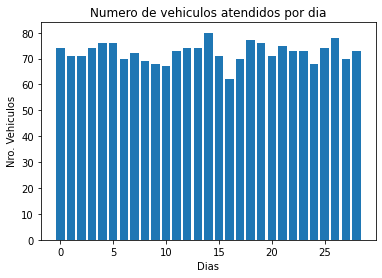


Numero de vehiculos atendidos por carril pesados [79, 77, 77, 69, 99, 76, 87, 74, 109, 86, 85, 71, 87, 82, 77, 78, 90, 68, 98, 72, 88, 86, 79, 84, 84, 67, 73, 83, 83]


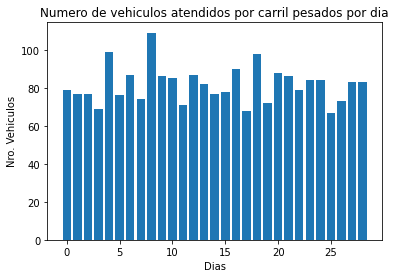


Numero de vehiculos atendidos por carril livianos [401, 403, 433, 439, 415, 430, 426, 433, 401, 430, 422, 436, 421, 431, 432, 428, 430, 441, 410, 436, 421, 428, 433, 429, 431, 440, 427, 426, 430]


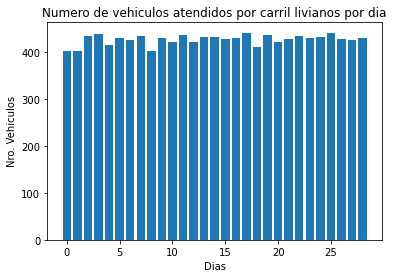


Numero de vehiculos aprobados por dia [44, 43, 37, 48, 43, 49, 40, 36, 41, 41, 40, 40, 45, 49, 39, 43, 33, 43, 47, 42, 39, 42, 38, 47, 47, 45, 44, 45, 41]


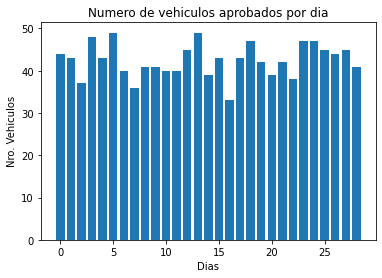


Numero de vehiculos rechazados por dia [31, 28, 35, 25, 33, 27, 30, 36, 28, 27, 27, 33, 29, 26, 40, 29, 28, 28, 29, 34, 32, 33, 35, 27, 20, 29, 34, 26, 31]


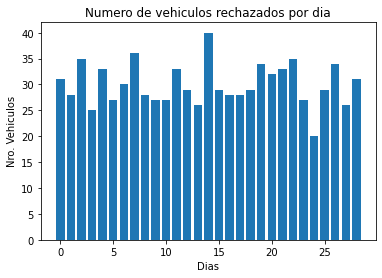

In [2]:
print('Numero de vehiculos atendidos por dia',vdias)
plt.bar(range(len(vdias)), vdias, align="center")
plt.title("Numero de vehiculos atendidos por dia")
plt.xlabel("Dias")
plt.ylabel("Nro. Vehiculos")
plt.show()
print()

print('Numero de vehiculos atendidos por carril pesados',vcpes)
plt.bar(range(len(vcpes)), vcpes, align="center")
plt.title("Numero de vehiculos atendidos por carril pesados por dia")
plt.xlabel("Dias")
plt.ylabel("Nro. Vehiculos")
plt.show()
print()
print('Numero de vehiculos atendidos por carril livianos',vcliv)
plt.bar(range(len(vcliv)), vcliv, align="center")
plt.title("Numero de vehiculos atendidos por carril livianos por dia")
plt.xlabel("Dias")
plt.ylabel("Nro. Vehiculos")
plt.show()
print()

print('Numero de vehiculos aprobados por dia',vap)
plt.bar(range(len(vap)), vap, align="center")
plt.title("Numero de vehiculos aprobados por dia")
plt.xlabel("Dias")
plt.ylabel("Nro. Vehiculos")
plt.show()
print()
print('Numero de vehiculos rechazados por dia',vrech)
plt.bar(range(len(vrech)), vrech, align="center")
plt.title("Numero de vehiculos rechazados por dia")
plt.xlabel("Dias")
plt.ylabel("Nro. Vehiculos")
plt.show()
print()

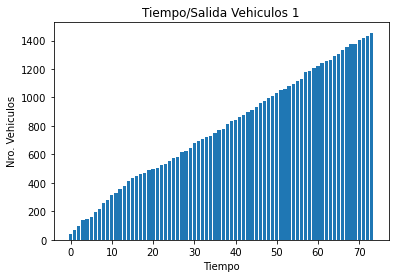

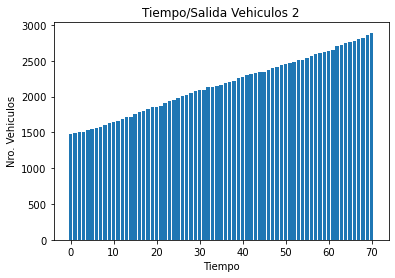

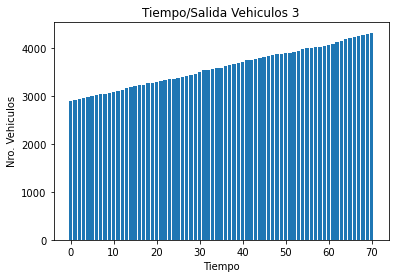

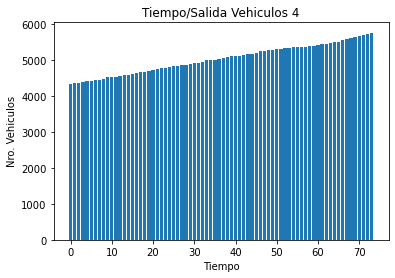

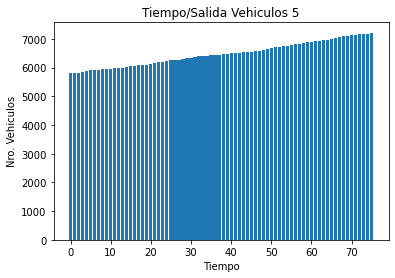

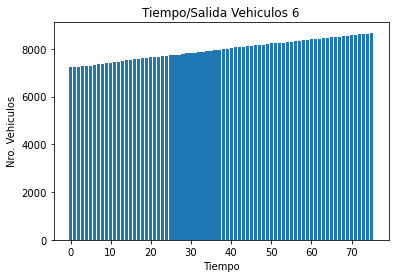

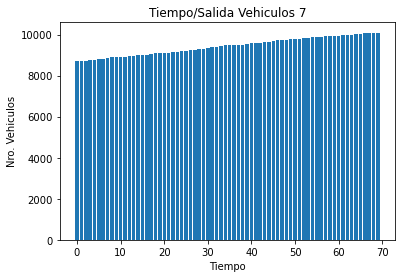

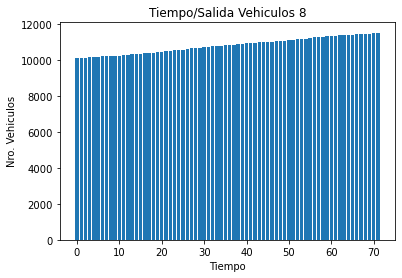

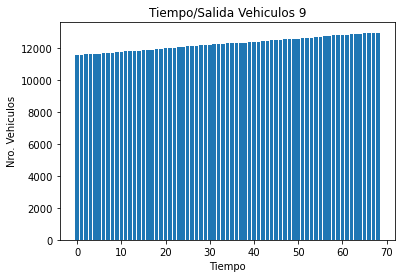

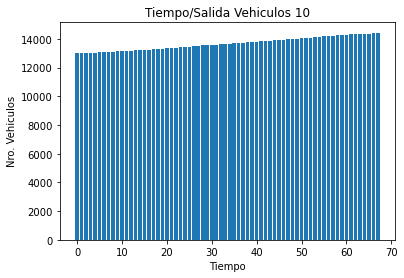

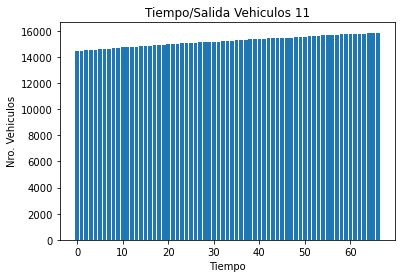

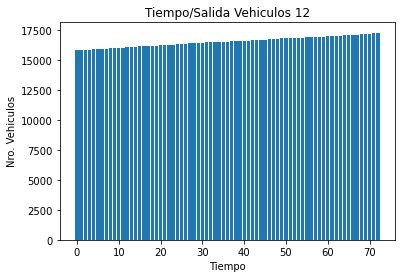

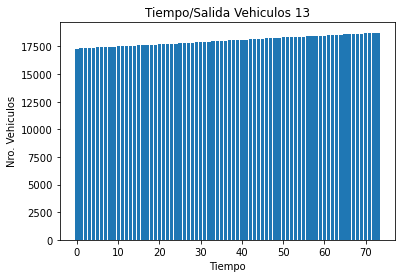

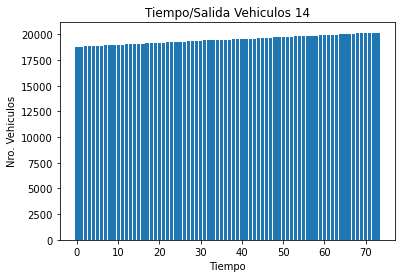

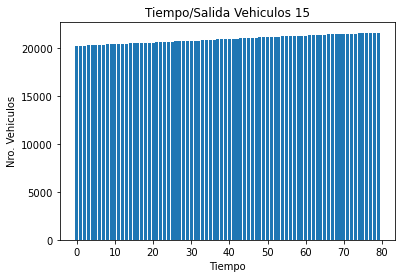

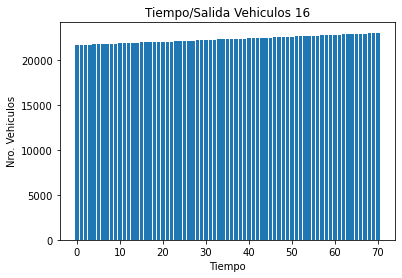

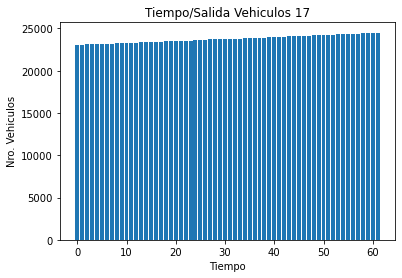

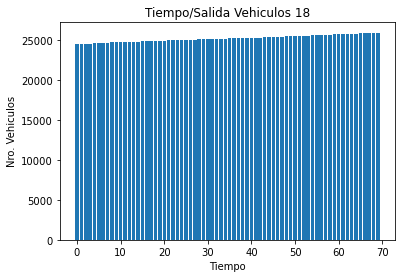

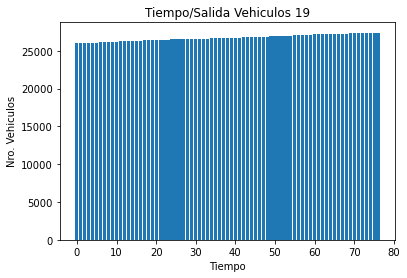

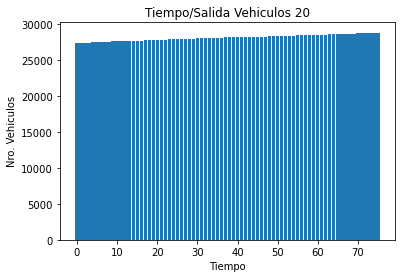

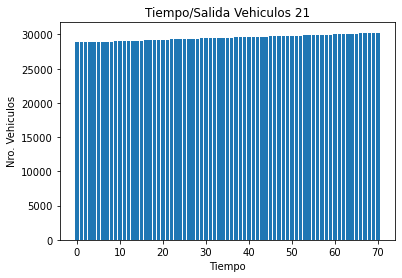

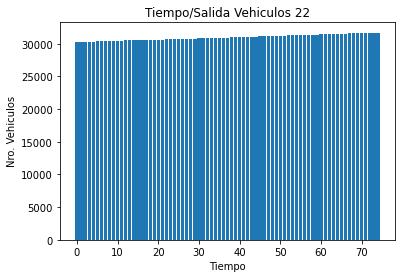

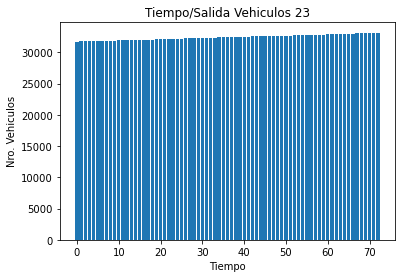

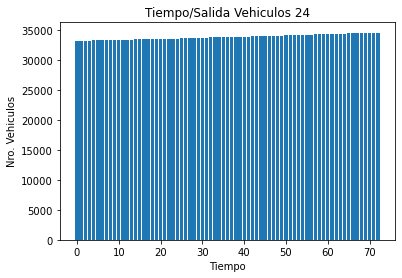

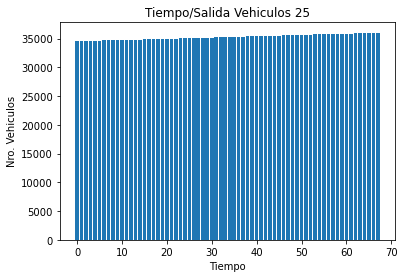

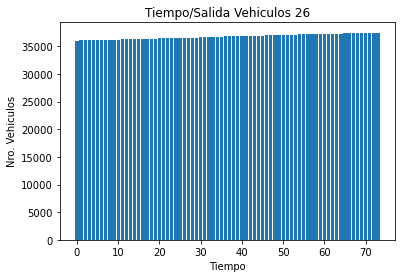

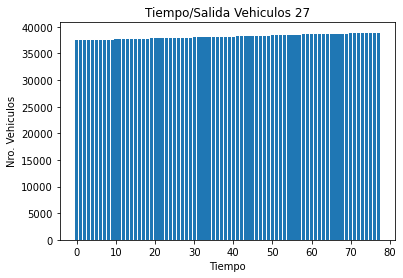

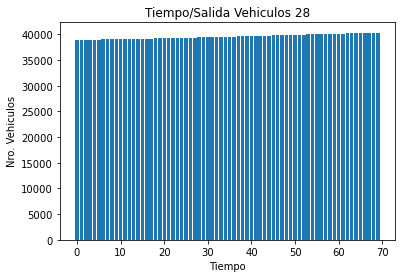

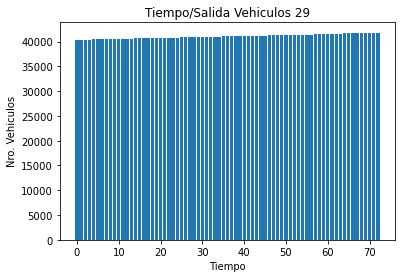

In [3]:
# print(tiempo)
# Generamos una grafica en base al diccionario del tiempo
c = 0
for t in tiempos:
  c+=1
  etiqueta = list(t.keys())
  valores = list(t.values())
  plt.bar(range(len(t)), etiqueta, align="center")
  plt.title(f"Tiempo/Salida Vehiculos {c}")
  plt.xlabel("Tiempo")
  plt.ylabel("Nro. Vehiculos")
  plt.show()